In [1]:
import pathlib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import load_model

from utils import create_dataset, data_reshaping, lstm_model, model_run, get_30_days_predictions
from plot_utils import plot_losses, predicted_plots, plot_30_days_predict

warnings.filterwarnings("ignore")

In [200]:
base_dir = pathlib.Path().absolute()
data = base_dir / 'Dataset'

# for file in data.iterdir():
stocks = [ file.stem for file in data.glob('*.csv*')]
stocks_df = [pd.read_csv(base_dir.joinpath('Dataset', f'{stock}.csv')) for stock in stocks]

In [3]:
stocks

['Natural Gas Corp of Utopia',
 'Northern Bank of Utopia',
 'Pacific Bank of Utopia',
 'Union Bank of Utopia',
 'United Utopia Energy Corporation',
 'Utopia Energy',
 'Utopia General Power',
 'Utopia Oil and Gas',
 'Utopia Petroleums',
 'Utopia Power Solutions',
 'Utopia Sublime Bank Group',
 'Utopian Bank',
 'Utopian Financial Services']

In [4]:
assert len(stocks_df) == len(stocks)

print(len(stocks), len(stocks_df))

13 13


In [201]:
# convert all date columns to datetime type & set the date as index
for df in stocks_df:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

Natural Gas Corp of Utopia
1428.42 || 1938.75 || 22871.430648259065 || 3321.3172


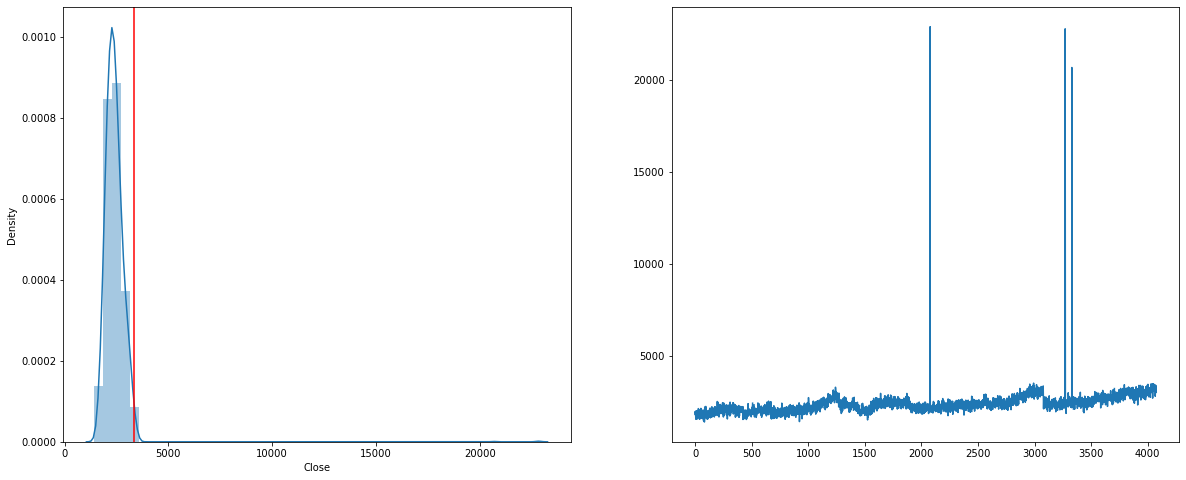

Northern Bank of Utopia
256.55 || 312.65 || 1991.682102789017 || 456.4581999999999


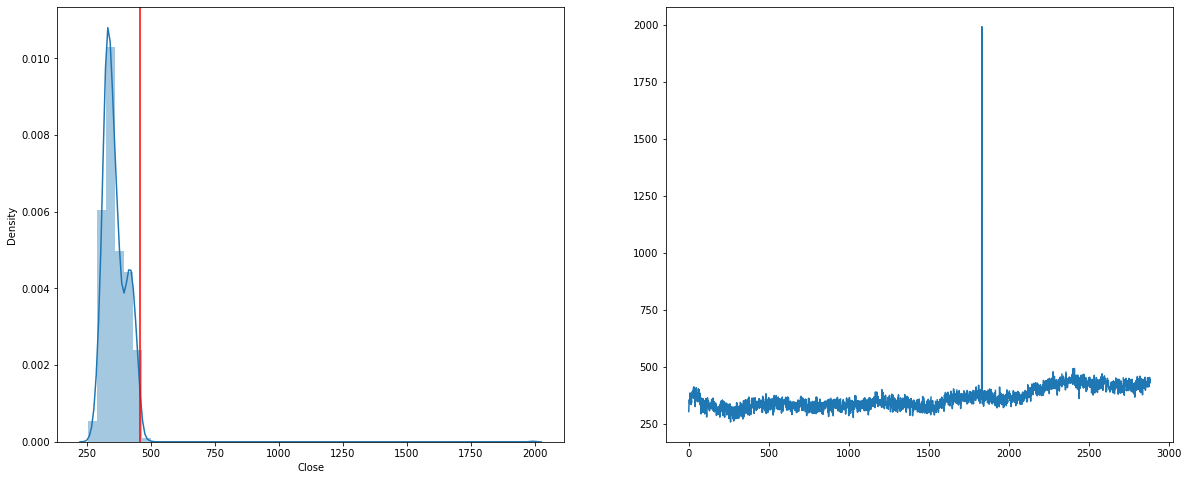

Pacific Bank of Utopia
1064.57 || 1602.239 || 22529.20263696753 || 2974.3928000000005


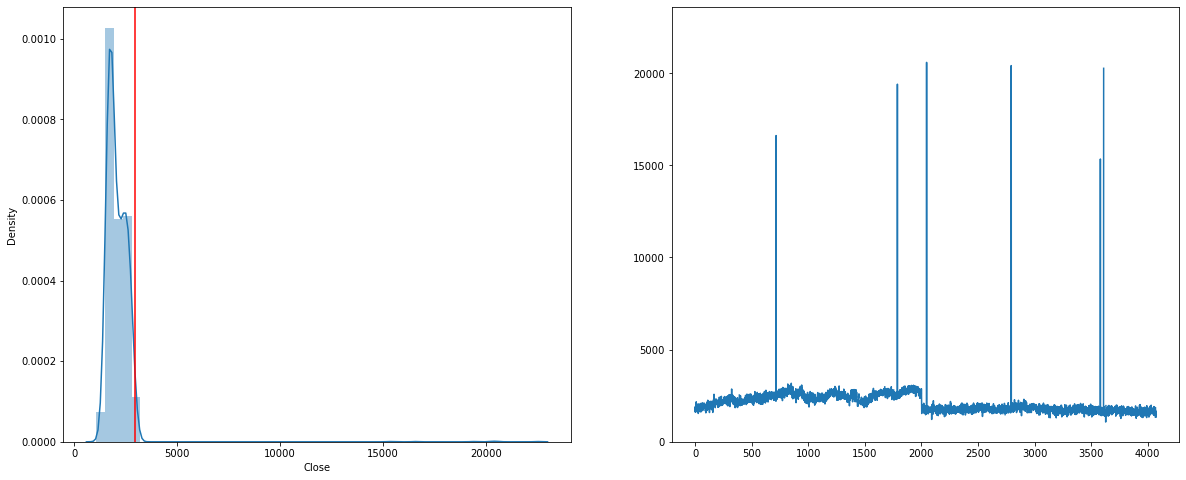

Union Bank of Utopia
301.67 || 391.906 || 3872.747623167671 || 539.0855999999999


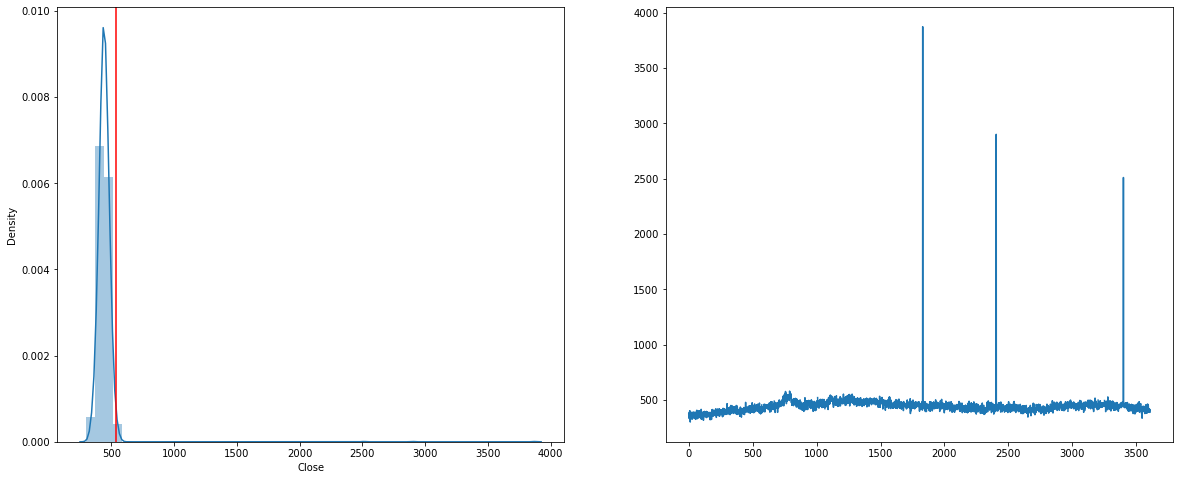

United Utopia Energy Corporation
2509.96 || 3553.9350000000004 || 55778.088968940014 || 6786.565000000001


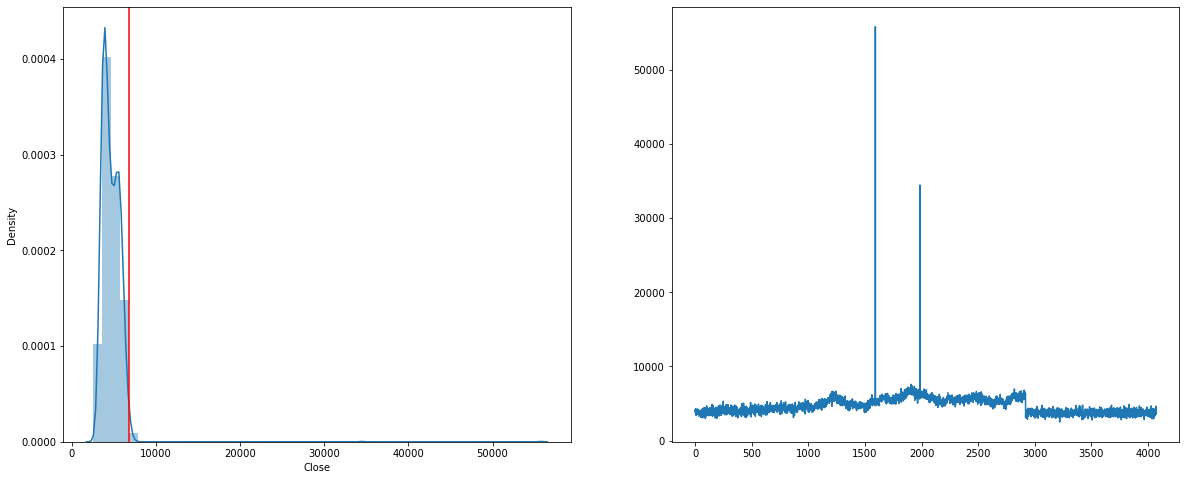

Utopia Energy
1430.27 || 1950.082 || 30347.8108921544 || 3439.2266


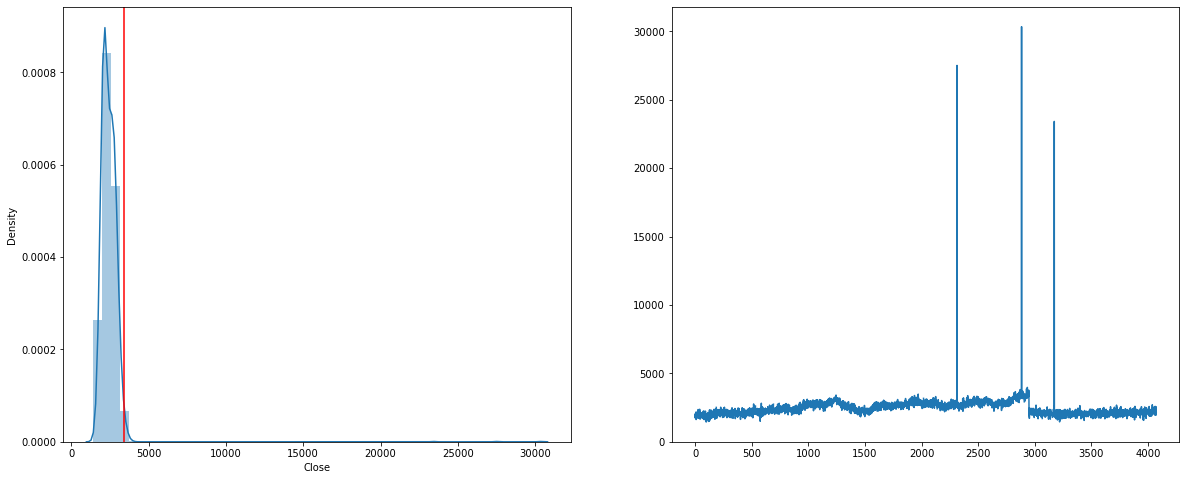

Utopia General Power
7807.0 || 10588.316 || 196766.696942168 || 19747.192199999998


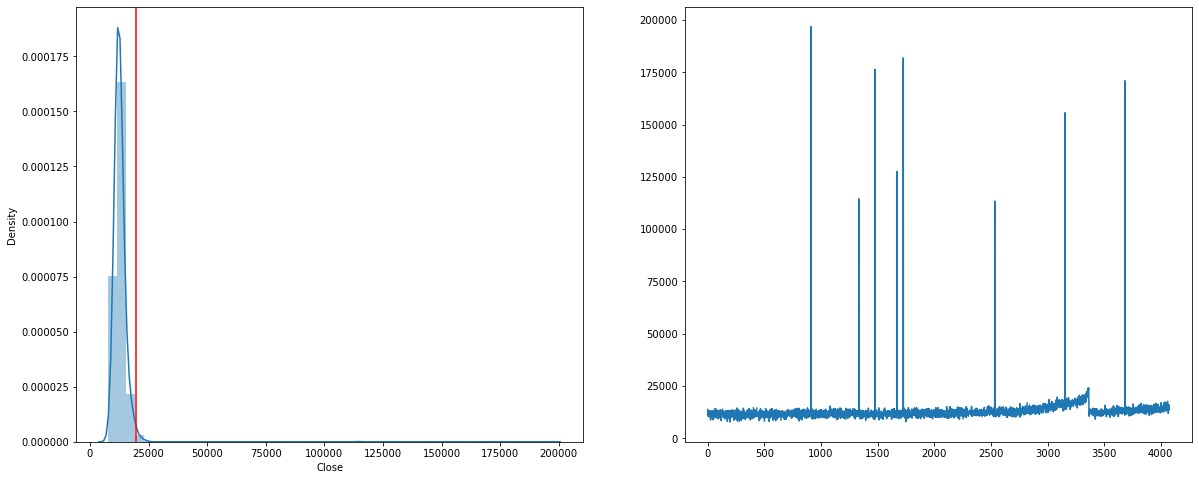

Utopia Oil and Gas
2054.31 || 2884.336 || 43351.21149738258 || 5191.574100000001


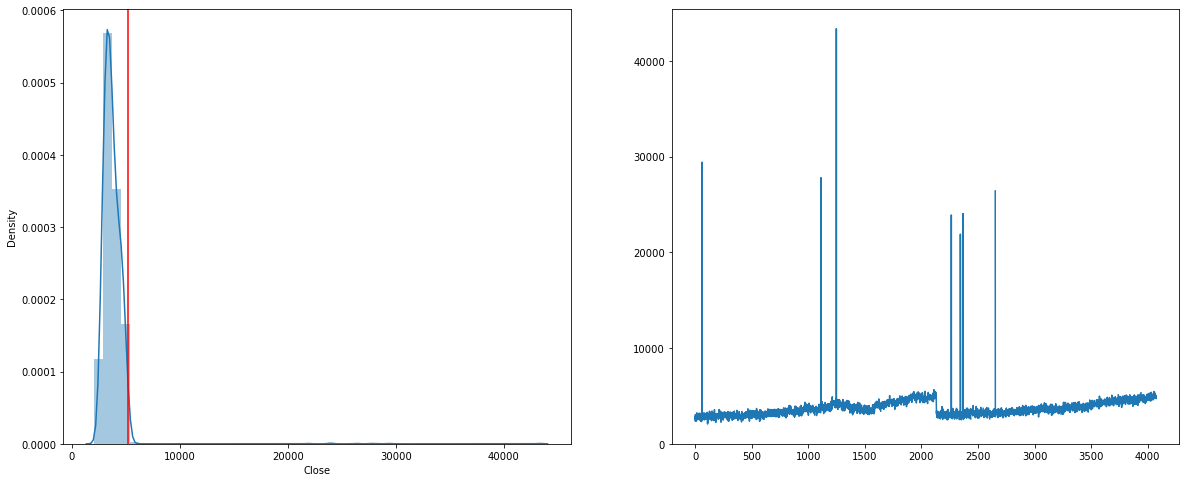

Utopia Petroleums
1486.06 || 1926.755 || 4521.88 || 4063.3525


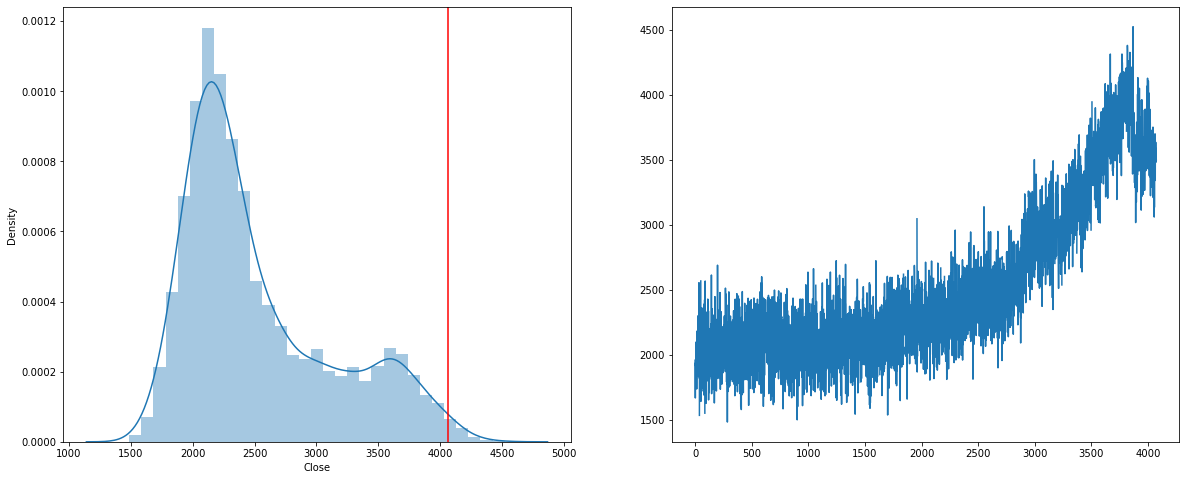

Utopia Power Solutions
1591.54 || 2145.046 || 33879.81906986774 || 3890.792399999998


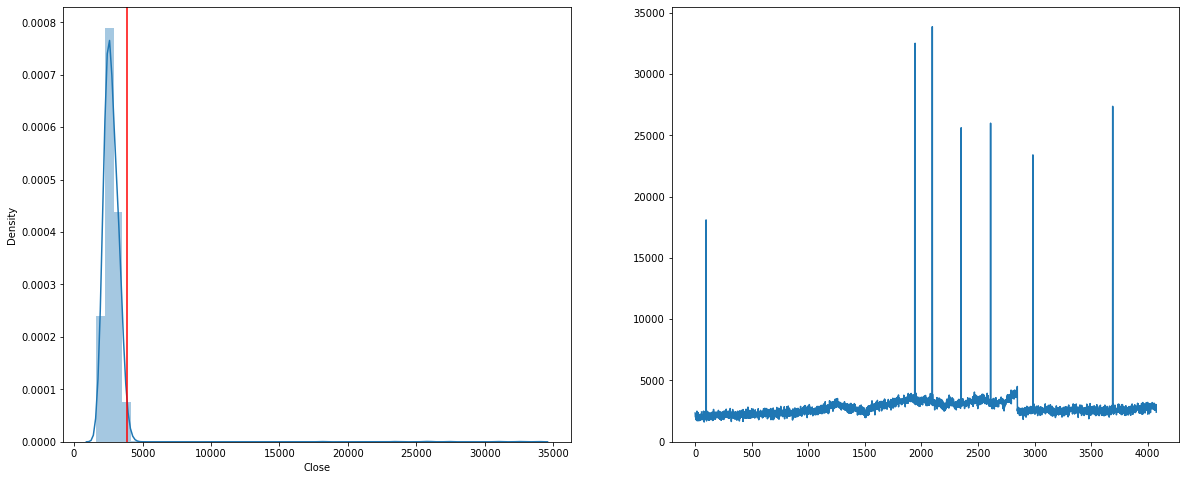

Utopia Sublime Bank Group
481.02 || 729.74 || 8678.006575750689 || 1106.37


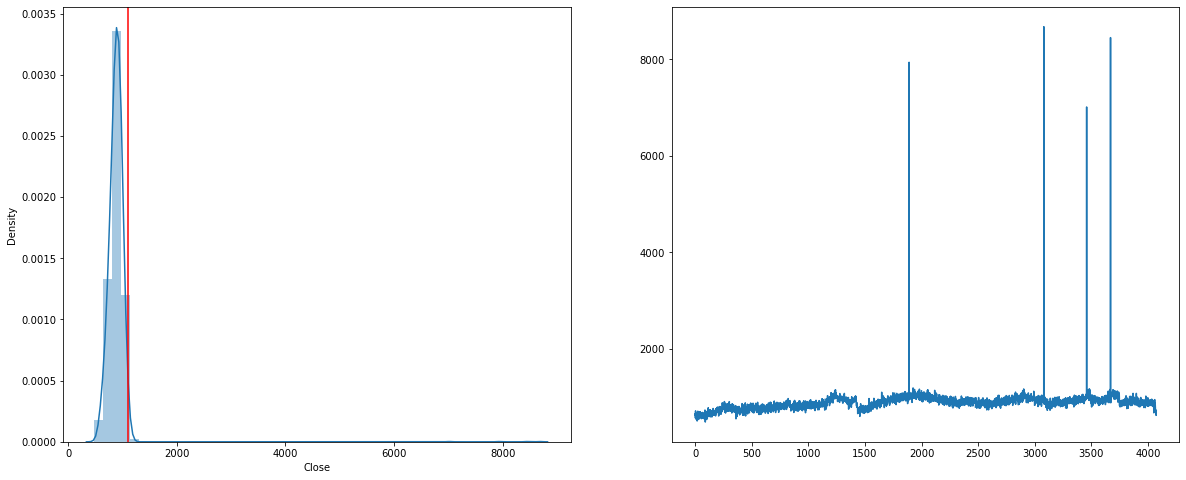

Utopian Bank
755.46 || 986.918 || 12961.537933472428 || 1490.4862


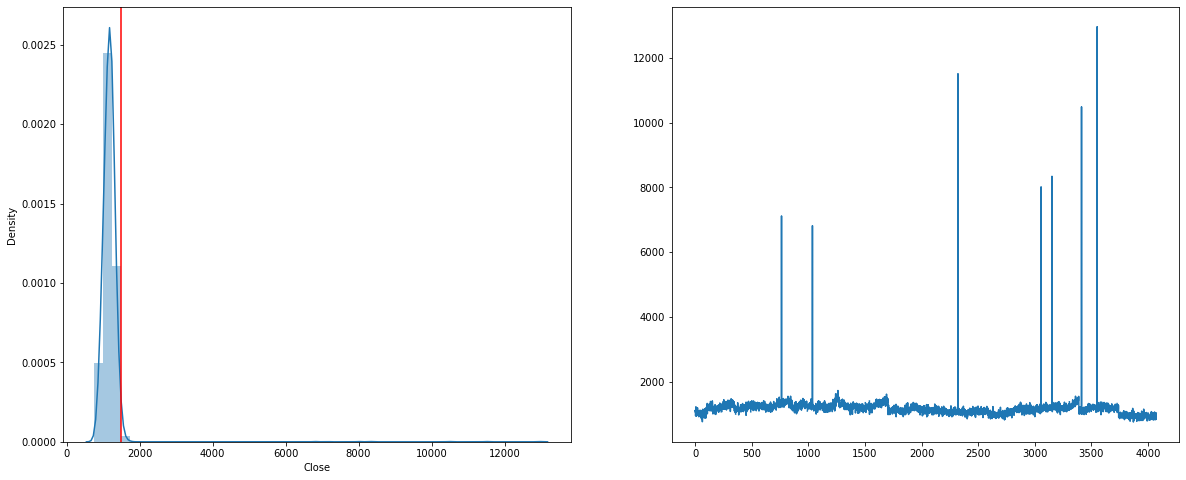

Utopian Financial Services
1087.27 || 1386.664 || 18059.59200592522 || 2163.1359


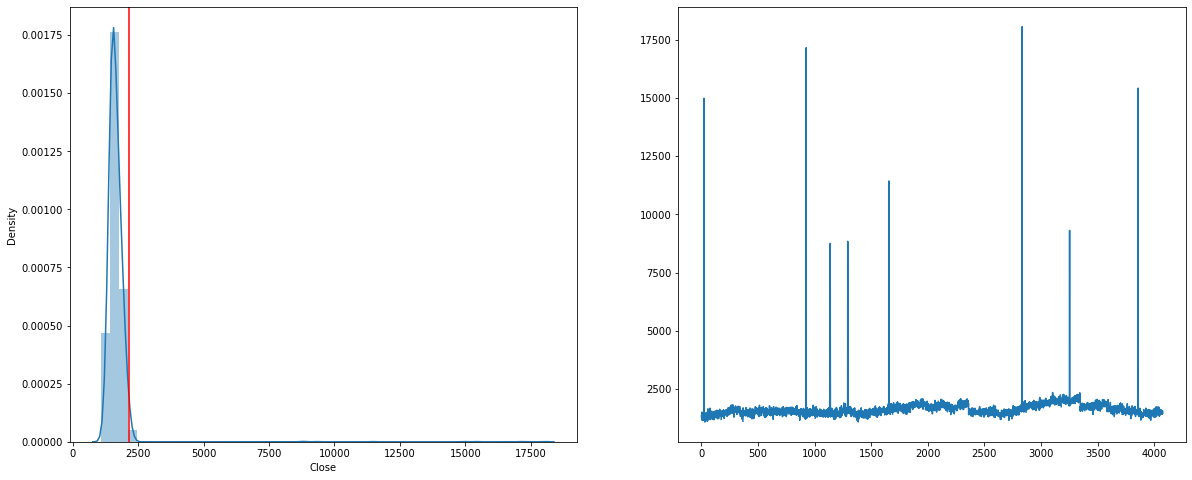

In [6]:
#  Distribution & line plots for all stocks

for df, stock_name in zip(stocks_df, stocks):
    print(stock_name)
    print(df['Close'].min(), '||', df['Close'].quantile(0.1), '||', df['Close'].max(), '||', df['Close'].quantile(0.99))
    fig, axs = plt.subplots(1,2, figsize =(20,8))
    fig1 = sns.distplot(df['Close'], ax=axs[0]) # bins=50, kde=True, height=5, aspect=1.5)
    fig1.axvline(df['Close'].quantile(0.99), color='red')
    df['Close'].plot(ax=axs[1])
    plt.show()

There are Statistical algorithms/models are available for forecasting time series, such as MA, ARIMA, SARIMA ... (depends on weighted moving averge & autoregression). To use these models, data should be stationary which means no seasonality & no trend. It means that, it needs to remove the trend & seasonality from the data. Once the model is trained and starts making predictions, needs to add the trend (if exists) & sesaonality pattern(if exists) to get the final predictions.

When we use ML/DL algorithms, it is generally not necessary to do all this. For this problem, I am planning to use LSTM neural network as they are capable of handling sequential/time series data. LSTM/RNNs have memory cells, which preserves some state (or information) across time steps till that time step t

The objective of this problem is to predict the stock price for next 30 working days and hence, will consider only **close** price feature for share price prediction (ML/DL) model.

To predict the stock price for next 30 days, will be using LSTM modelling approach for stock prediction

P.S: SARIMA which is an extension of ARIMA that models the seasonal element.

### Natural Gas Corp of Utopia stock analysis

In [7]:
stocks_df[0].head()

Date     Open     High      Low    Close
0 2043-01-01  1845.59  1875.74  2042.98  1968.77
1 2043-01-02  2121.87  1539.50  1954.12  1954.04
2 2043-01-03  1688.39  1998.92  1893.22  1811.95
3 2043-01-06  1577.40  2047.06  1704.66  1928.24
4 2043-01-07  2067.43  2019.37  1493.44  2020.46

In [8]:
print(f'Natural Gas Corp of Utopia stock prices between {stocks_df[0].Date.min()} and {stocks_df[0].Date.max()}')
print(f'Total trading Days = {(stocks_df[0].Date.max() - stocks_df[0].Date.min()).days}')

Natural Gas Corp of Utopia stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

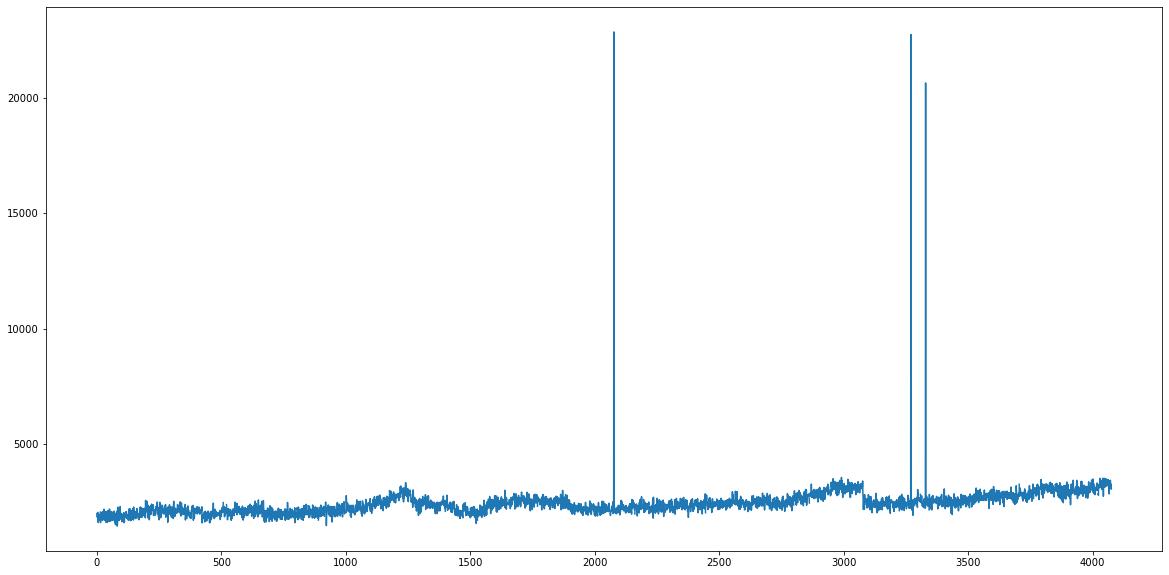

In [9]:
# plt.figure(figsize=(20,10))
stocks_df[0]['Close'].plot(figsize=(20,10))

In [10]:
stocks_df[0].describe()

Open          High           Low         Close
count   3996.000000   3979.000000   3978.000000   4005.000000
mean    2418.637838   2420.615494   2401.202758   2410.034180
std      798.524241    701.913550    637.722370    658.301920
min     1363.170000   1404.920000   1492.890000   1428.420000
25%     2120.257500   2126.730000   2105.357500   2117.670000
50%     2358.860000   2370.770000   2353.070000   2355.890000
75%     2630.537500   2640.380000   2622.000000   2635.870000
max    27950.678306  26000.443711  19964.757553  22871.430648

Observed that there are outliers in **Natural Gas Corp of Utopia** stock & needs to filter the same

1428.42 || 1938.75 || 22871.430648259065 || 3538.904959999995


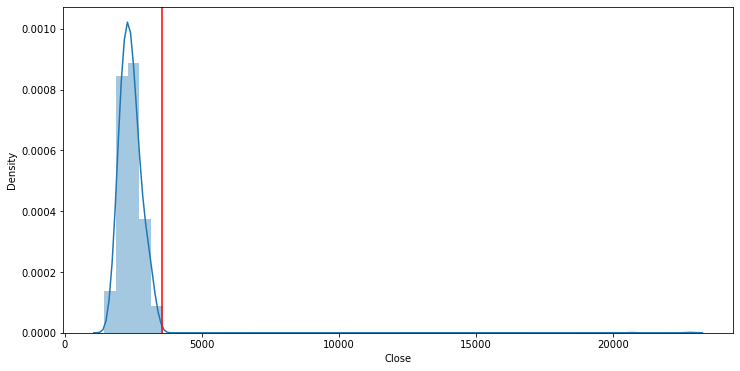

In [11]:
print(stocks_df[0]['Close'].min(), '||', stocks_df[0]['Close'].quantile(0.1), '||', stocks_df[0]['Close'].max(), '||', stocks_df[0]['Close'].quantile(0.99925))
plt.figure(figsize=(12,6))
sns.distplot(stocks_df[0]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[0]['Close'].quantile(0.99925), color='red')

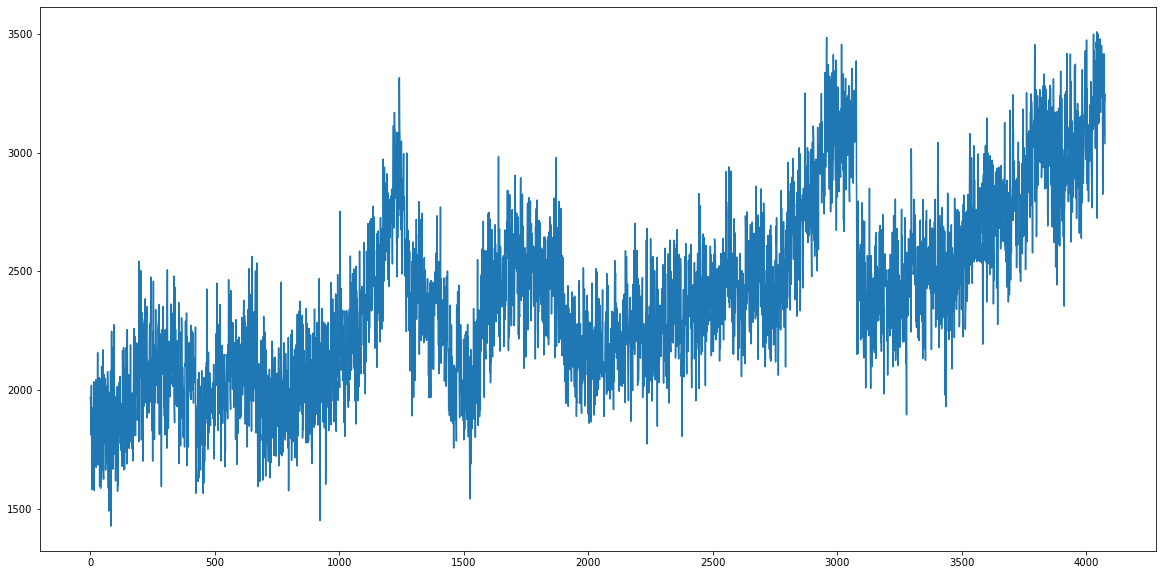

In [12]:
# removing the outliers
val = stocks_df[0]['Close'].quantile(0.99925)
stocks_df[0] = stocks_df[0][stocks_df[0]['Close'] <= val]
stocks_df[0]['Close'].plot(figsize=(20,10))
plt.show()

In [13]:
stocks_df[0].describe()

Open          High           Low        Close
count   3921.000000   3907.000000   3904.000000  4001.000000
mean    2419.176300   2421.896704   2402.465515  2394.992152
std      804.618430    706.655931    641.733317   376.638526
min     1363.170000   1404.920000   1492.890000  1428.420000
25%     2119.610000   2126.570000   2106.602500  2117.670000
50%     2359.370000   2371.690000   2353.345000  2355.690000
75%     2632.330000   2642.625000   2624.530000  2633.340000
max    27950.678306  26000.443711  19964.757553  3507.320000

In [14]:
df = stocks_df[0].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1968.77
1    1954.04
2    1811.95
3    1928.24
4    2020.46
Name: Close, dtype: float64


0

There is no null data

Preprocess & Split the data into train & test split

In [15]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
train_data.shape, test_data.shape

Training_size : 3200, Test_size : 801 


((3200, 1), (801, 1))

In [16]:
X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3139, 60) (3139,)
(740, 60) (740,)


In [17]:

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

model = lstm_model(X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,049
Trainable params: 338,049
Non-trai

In [18]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, 0, 100, 64)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.0711
Epoch 1: val_loss improved from inf to 0.04745, saving model to Natural Gas Corp of Utopia_model.h5
50/50 [==============================] - 18s 258ms/step - loss: 0.0711 - val_loss: 0.0475
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.0343
Epoch 2: val_loss improved from 0.04745 to 0.04206, saving model to Natural Gas Corp of Utopia_model.h5
50/50 [==============================] - 11s 231ms/step - loss: 0.0343 - val_loss: 0.0421
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.0364
Epoch 3: val_loss improved from 0.04206 to 0.03516, saving model to Natural Gas Corp of Utopia_model.h5
50/50 [==============================] - 13s 258ms/step - loss: 0.0364 - val_loss: 0.0352
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.0335
Epoch 4: val_loss did not improve from 0.03516
50/50 [==============================] - 13s 253ms/step - loss: 0.0335 

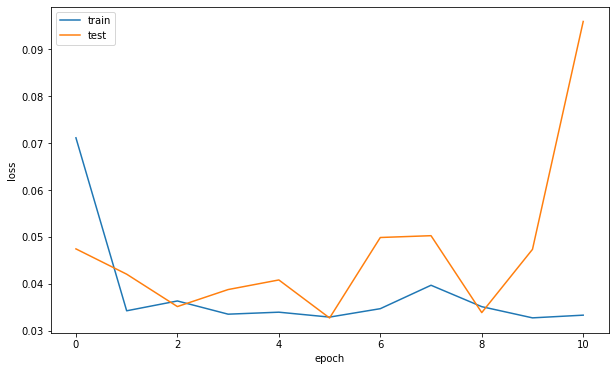

In [19]:
plt.figure(figsize=(10,6))
plot_losses(history)

In [20]:
f'{stocks[0]}_model.h5'

'Natural Gas Corp of Utopia_model.h5'

In [21]:
saved_model = load_model(f'{stocks[0]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

24/24 [==============================] - 1s 38ms/step
180.6593612081455 188.04061667475779


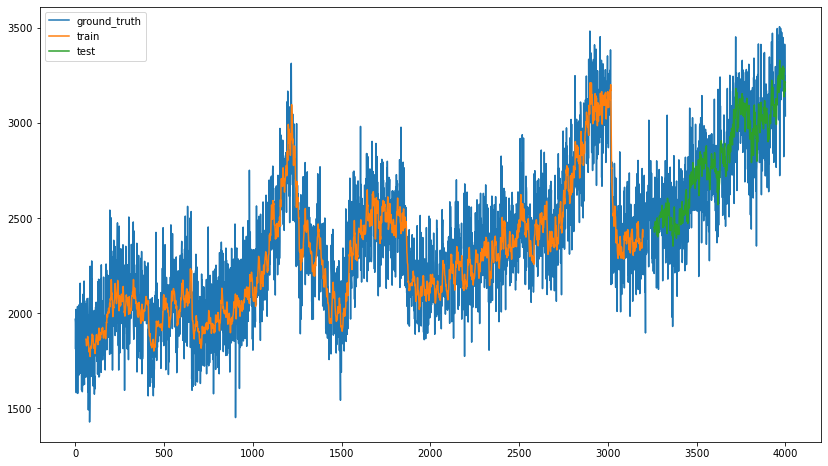

In [22]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

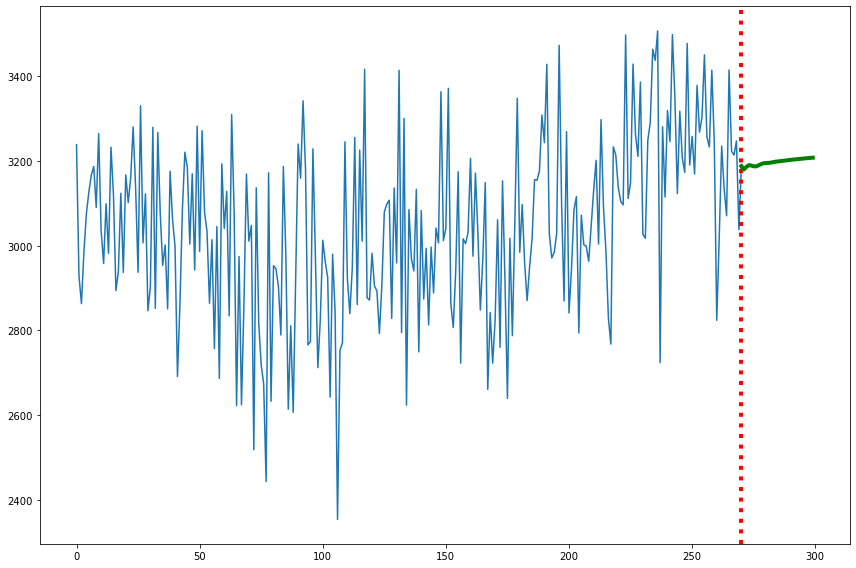

In [23]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Northern Bank of Utopia stock analysis

In [24]:
stock_id=1

In [25]:
print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')

        Date    Open    High     Low   Close
0 2047-10-05  300.11  334.84  309.06  302.55
1 2047-10-08  342.53  338.48  343.03  323.23
2 2047-10-09  312.67  325.01  267.73  337.17
3 2047-10-10  355.18  355.15  321.54  337.20
4 2047-10-11  327.23  339.76  299.04  355.21
Northern Bank of Utopia stock prices between 2047-10-05 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 4305


<AxesSubplot:>

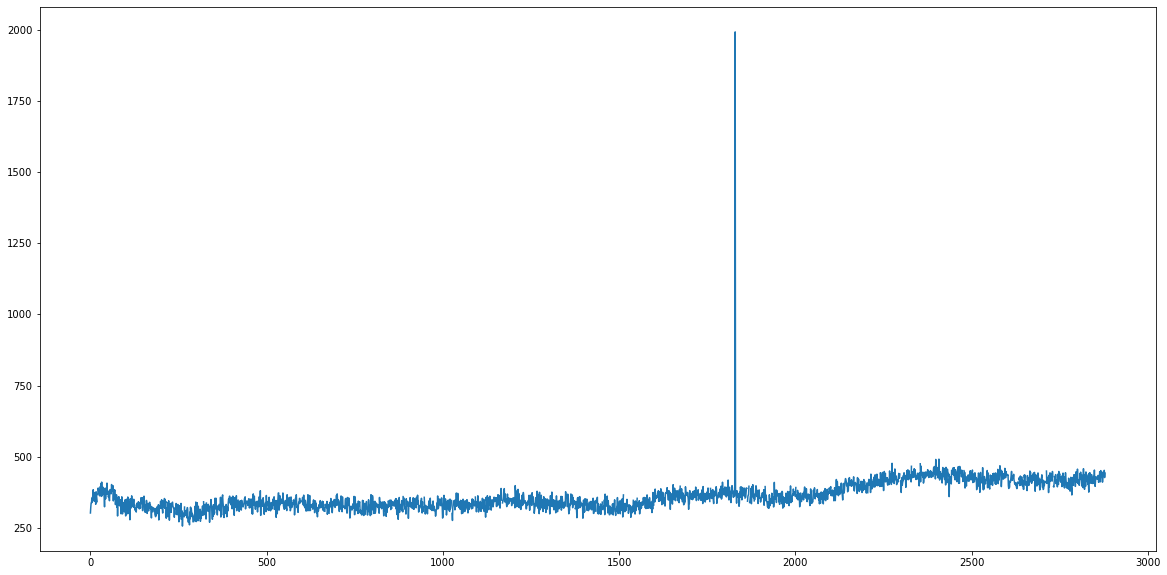

In [26]:
stocks_df[stock_id]['Close'].plot(figsize=(20,10))

In [27]:
stocks_df[stock_id].describe()

Open         High          Low        Close
count  2829.000000  2827.000000  2835.000000  2814.000000
mean    364.673884   362.778960   366.092353   361.130758
std     105.046904    44.004507   146.260755    53.116074
min     252.280000   268.430000   251.720000   256.550000
25%     328.050000   328.415000   325.700000   327.735000
50%     350.360000   352.660000   348.170000   350.040000
75%     395.690000   397.220000   391.900000   393.095000
max    3718.889651   481.170000  3835.432324  1991.682103

Observed that there are outliers in **Northern Bank of Utopia** stock & needs to filter the same

256.55 || 312.65 || 1991.682102789017 || 491.31065499999994


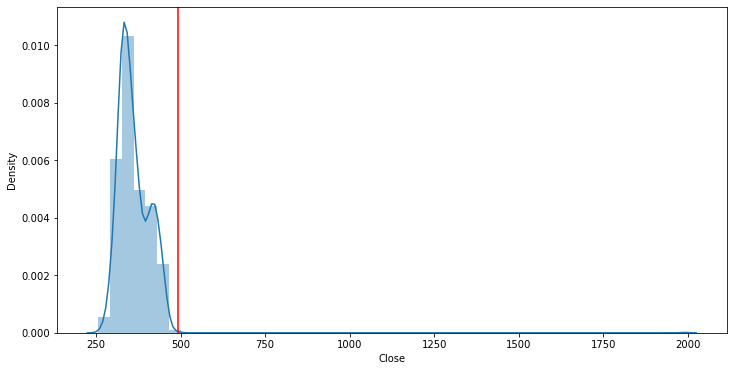

In [28]:
print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9995))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9995), color='red')

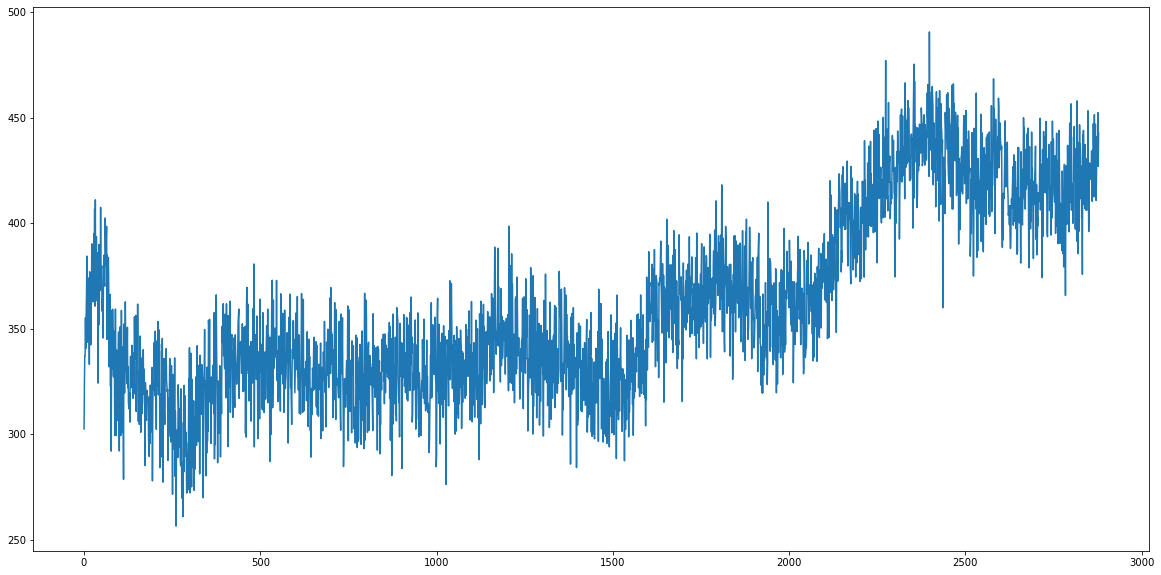

In [29]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9995)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [30]:
stocks_df[stock_id].describe()

Open         High          Low        Close
count  2763.000000  2760.000000  2770.000000  2812.000000
mean    364.866771   362.889482   366.348690   360.504445
std     106.080502    43.996495   147.766897    43.255540
min     252.280000   268.430000   251.720000   256.550000
25%     328.140000   328.672500   325.867500   327.692500
50%     350.800000   352.750000   348.220000   349.970000
75%     395.700000   397.250000   391.910000   392.952500
max    3718.889651   481.170000  3835.432324   490.640000

In [31]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    302.55
1    323.23
2    337.17
3    337.20
4    355.21
Name: Close, dtype: float64


0

There is no Null data

Preprocess & split the data

In [32]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
train_data.shape, test_data.shape

Training_size : 2249, Test_size : 563 


((2249, 1), (563, 1))

In [33]:
X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

model = lstm_model(X_train)
model.summary()

(2188, 60) (2188,)
(502, 60) (502,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,

In [34]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 0.0849
Epoch 1: val_loss improved from inf to 0.03529, saving model to Northern Bank of Utopia_model.h5
35/35 [==============================] - 14s 260ms/step - loss: 0.0849 - val_loss: 0.0353
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.0297
Epoch 2: val_loss improved from 0.03529 to 0.02582, saving model to Northern Bank of Utopia_model.h5
35/35 [==============================] - 8s 241ms/step - loss: 0.0297 - val_loss: 0.0258
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.0277
Epoch 3: val_loss improved from 0.02582 to 0.02410, saving model to Northern Bank of Utopia_model.h5
35/35 [==============================] - 9s 252ms/step - loss: 0.0277 - val_loss: 0.0241
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 0.0272
Epoch 4: val_loss did not improve from 0.02410
35/35 [==============================] - 9s 250ms/step - loss: 0.0272 - val_loss: 

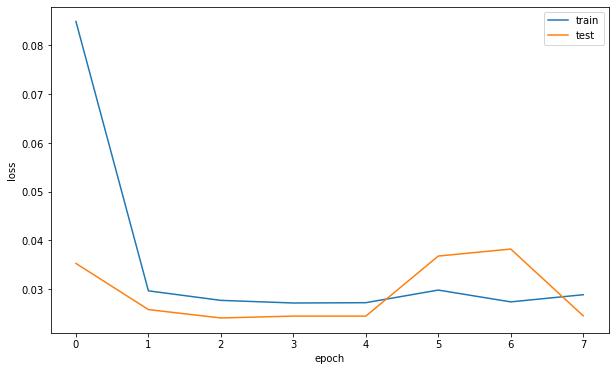

In [35]:
plt.figure(figsize=(10,6))
plot_losses(history)

In [36]:
f'{stocks[stock_id]}_model.h5'

'Northern Bank of Utopia_model.h5'

In [37]:
saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

16/16 [==============================] - 1s 45ms/step
19.187915890668126 18.169725462916897


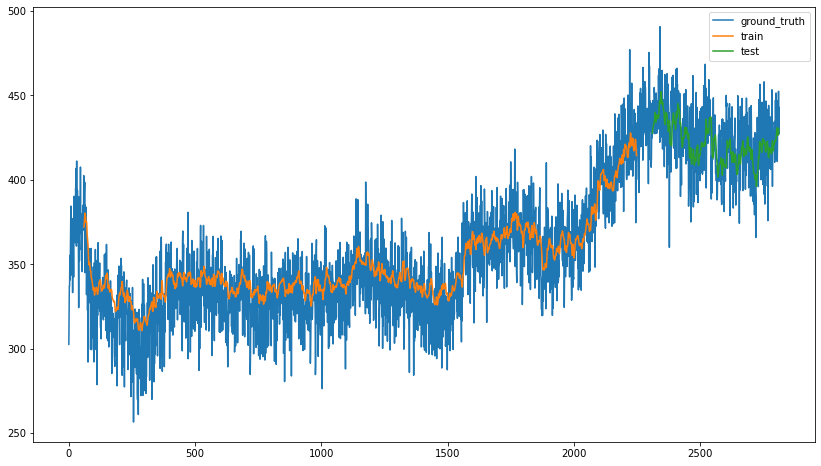

In [38]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

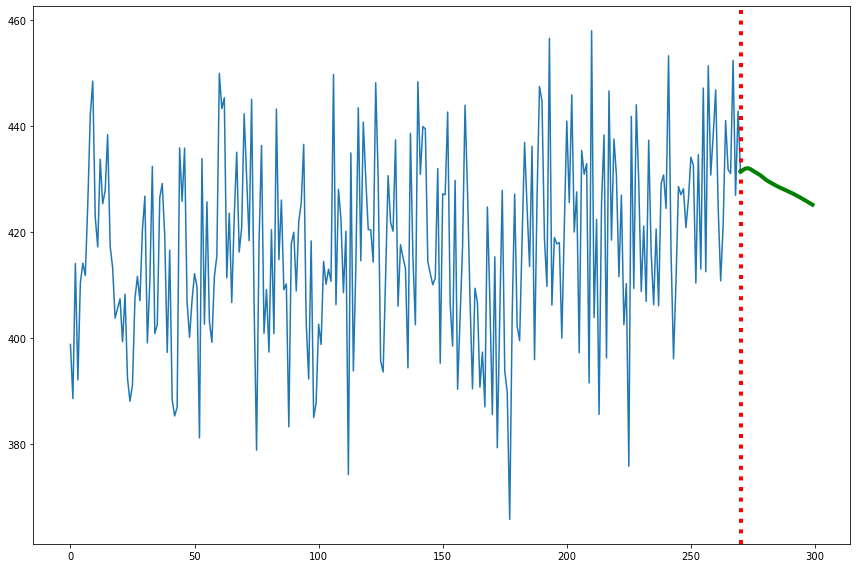

In [39]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Pacific Bank of Utopia Stock analysis

In [40]:
stock_id=2

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')

        Date     Open     High      Low    Close
0 2043-01-01  1740.74  1690.11  1766.31  1836.67
1 2043-01-02  1757.21      NaN  1966.38  1643.45
2 2043-01-03  1982.02  1881.88  1707.20  1899.35
3 2043-01-06  1626.34  1712.77  1777.40  1589.20
4 2043-01-07  1731.30  1926.68  1687.02  1821.98
Pacific Bank of Utopia stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

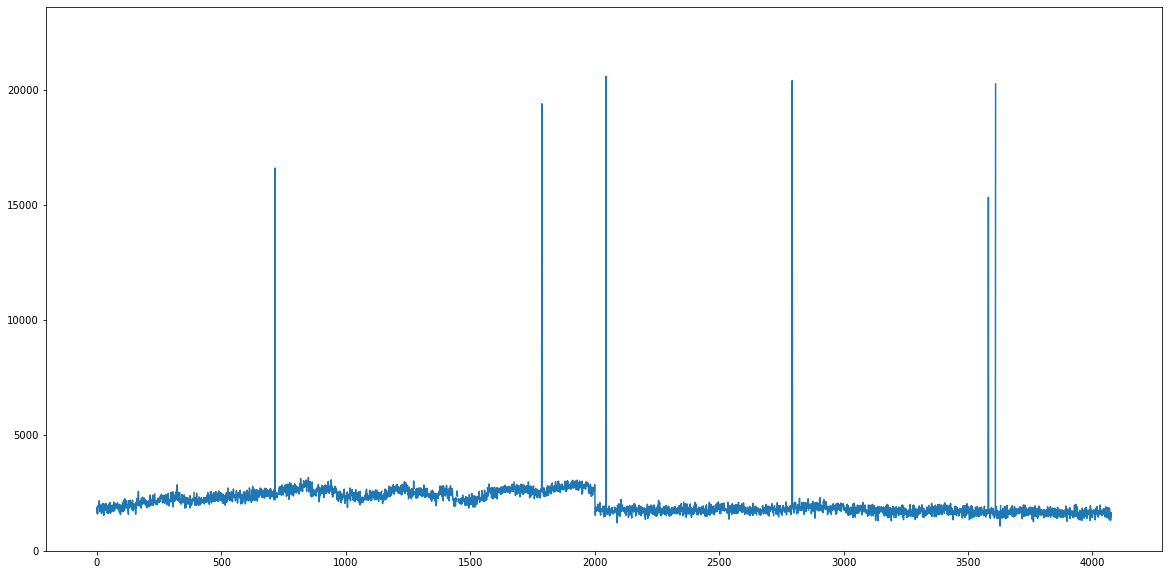

In [41]:
stocks_df[stock_id]['Close'].plot(figsize=(20,10))

Observed that there are outliers in **Pacific Bank of Utopia** stock & needs to filter the same

1064.57 || 1602.239 || 22529.20263696753 || 3163.08055399999


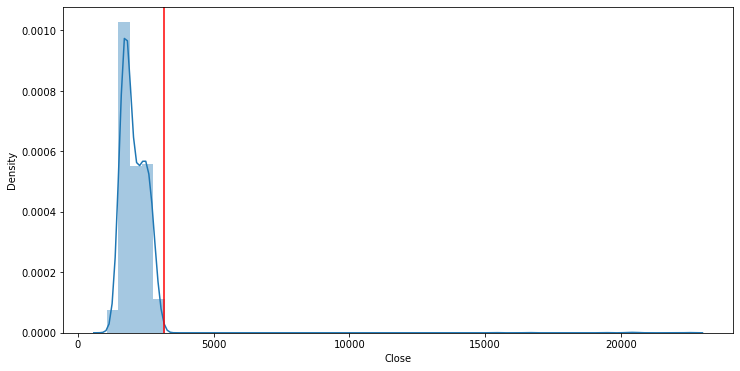

In [43]:
print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9982))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9982), color='red')

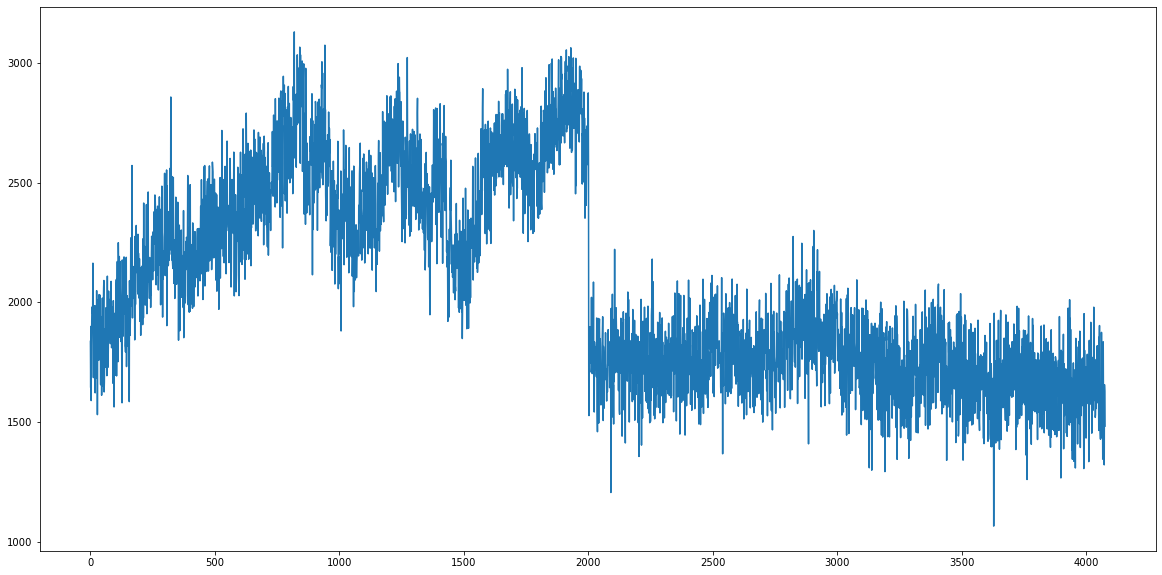

In [44]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9982)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [45]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1836.67
1    1643.45
2    1899.35
3    1589.20
4    1821.98
Name: Close, dtype: float64


0

There is no Null data

Preprocess & split the data

In [46]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

model = lstm_model(X_train)
model.summary()

Training_size : 3185, Test_size : 797 
(3185, 1) (797, 1)
(3124, 60) (3124,)
(736, 60) (736,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                          

In [47]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0591
Epoch 1: val_loss improved from inf to 0.01974, saving model to Pacific Bank of Utopia_model.h5
49/49 [==============================] - 28s 486ms/step - loss: 0.0591 - val_loss: 0.0197
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0275
Epoch 2: val_loss did not improve from 0.01974
49/49 [==============================] - 23s 467ms/step - loss: 0.0275 - val_loss: 0.0212
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0264
Epoch 3: val_loss did not improve from 0.01974
49/49 [==============================] - 24s 482ms/step - loss: 0.0264 - val_loss: 0.0207
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0276
Epoch 4: val_loss did not improve from 0.01974
49/49 [==============================] - 24s 497ms/step - loss: 0.0276 - val_loss: 0.0289
Epoch 5/100
49/49 [==============================] - ETA: 0s - loss: 0.0272
Epoch 5: val_loss did n

In [48]:
f'{stocks[stock_id]}_model.h5'

'Pacific Bank of Utopia_model.h5'

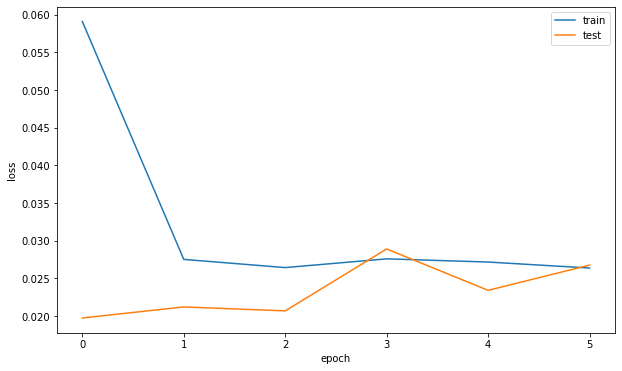

23/23 [==============================] - 2s 79ms/step
162.47005974021016 145.09006767867703


In [49]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

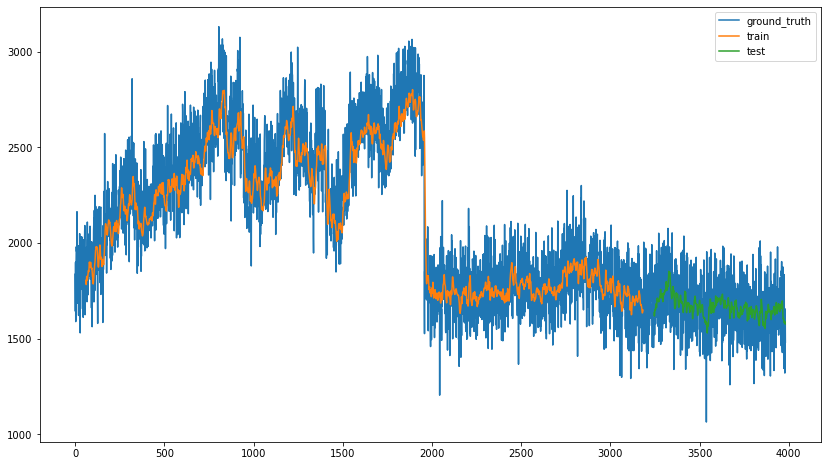

In [50]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

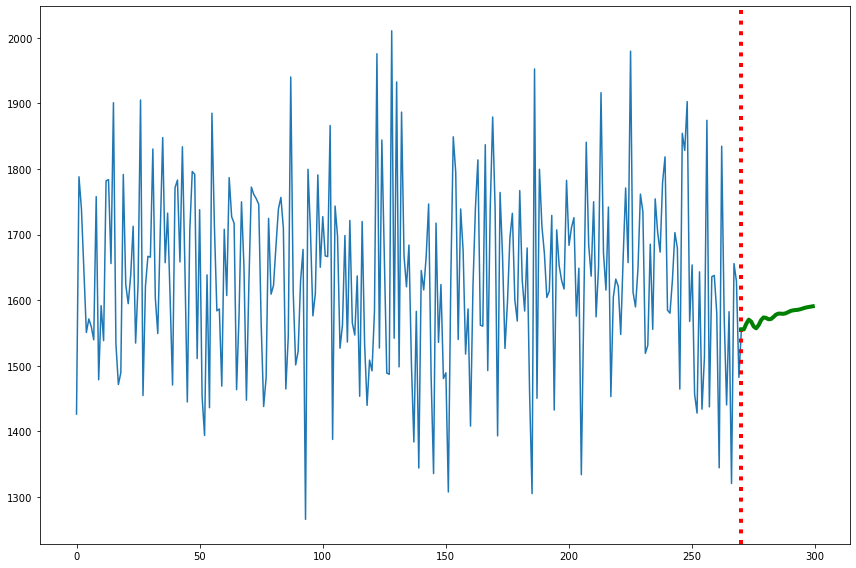

In [51]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Union Bank of Utopia Stock Analysis

In [52]:
stock_id = 3

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')

        Date    Open         High     Low   Close
0 2044-11-05  385.37  4297.094789  372.45  372.05
1 2044-11-08  349.21   367.190000  345.40  339.56
2 2044-11-09  356.76   352.350000  355.69  343.57
3 2044-11-10  371.62   376.190000  363.91  344.62
4 2044-11-11  363.73   384.970000  323.14  390.63
Union Bank of Utopia stock prices between 2044-11-05 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 5369


<AxesSubplot:>

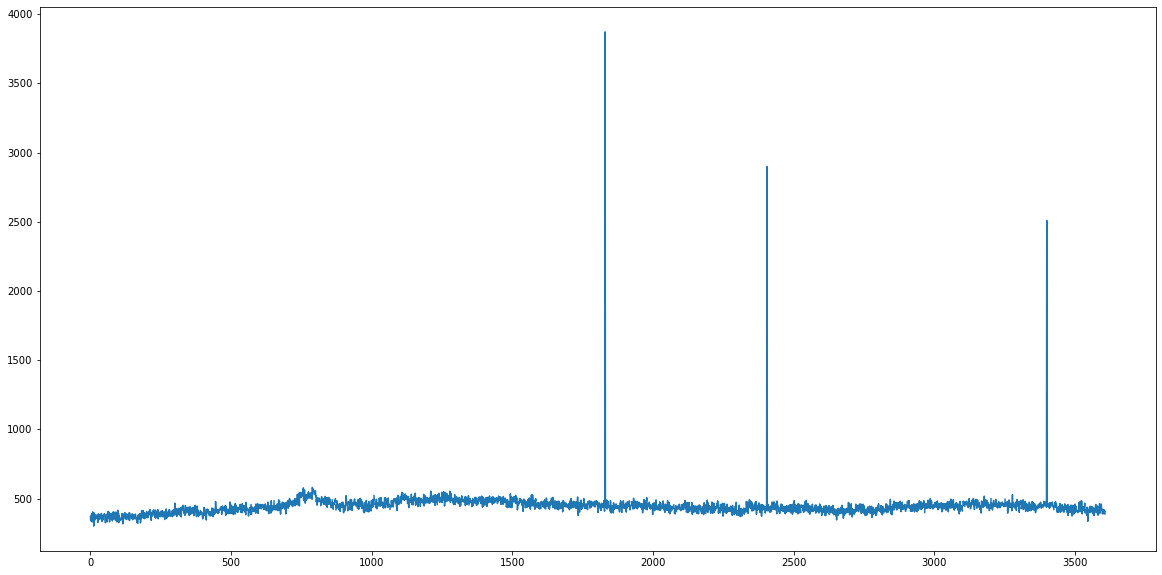

In [53]:
stocks_df[stock_id]['Close'].plot(figsize=(20,10))

Observed that there are outliers in **Union Bank of Utopia** stock & needs to filter the same

301.67 || 391.906 || 3872.747623167671 || 580.6013519999996


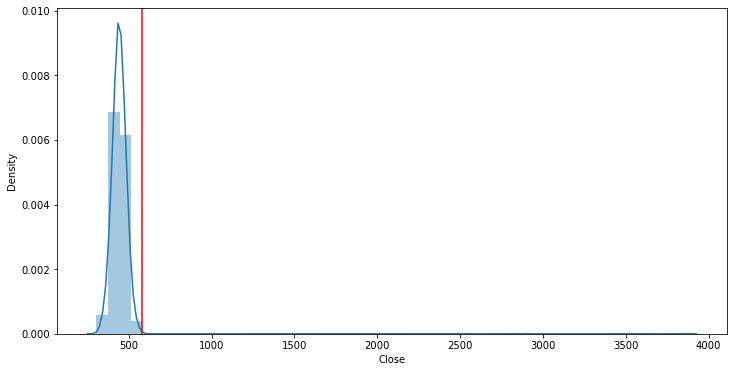

In [54]:
print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9991))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9991), color='red')

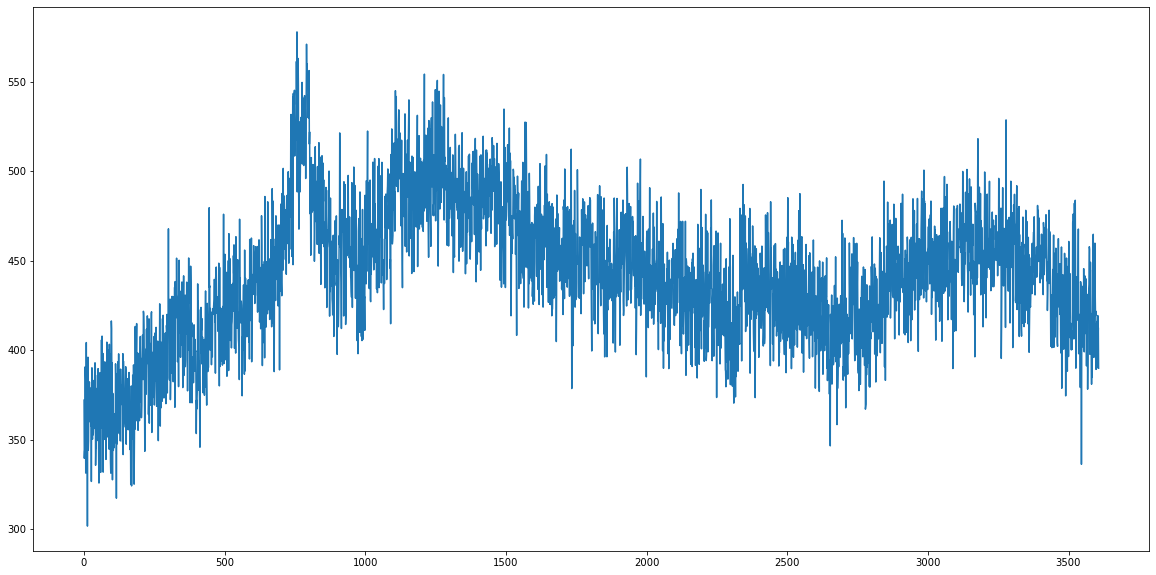

In [55]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9991)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [56]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    372.05
1    339.56
2    343.57
3    344.62
4    390.63
Name: Close, dtype: float64


0

- There is no Null Data

Now preprocess the data & split the data into train & test

In [57]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

model = lstm_model(X_train)
model.summary()

Training_size : 2823, Test_size : 706 
(2823, 1) (706, 1)
(2762, 60) (2762,)
(645, 60) (645,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_10 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                          

In [58]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.0593
Epoch 1: val_loss improved from inf to 0.02487, saving model to Union Bank of Utopia_model.h5
44/44 [==============================] - 30s 565ms/step - loss: 0.0593 - val_loss: 0.0249
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.0315
Epoch 2: val_loss did not improve from 0.02487
44/44 [==============================] - 24s 545ms/step - loss: 0.0315 - val_loss: 0.0280
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 0.0317
Epoch 3: val_loss did not improve from 0.02487
44/44 [==============================] - 25s 558ms/step - loss: 0.0317 - val_loss: 0.0288
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 0.0319
Epoch 4: val_loss improved from 0.02487 to 0.02448, saving model to Union Bank of Utopia_model.h5
44/44 [==============================] - 25s 574ms/step - loss: 0.0319 - val_loss: 0.0245
Epoch 5/100
44/44 [==============================]

In [59]:
f'{stocks[stock_id]}_model.h5'

'Union Bank of Utopia_model.h5'

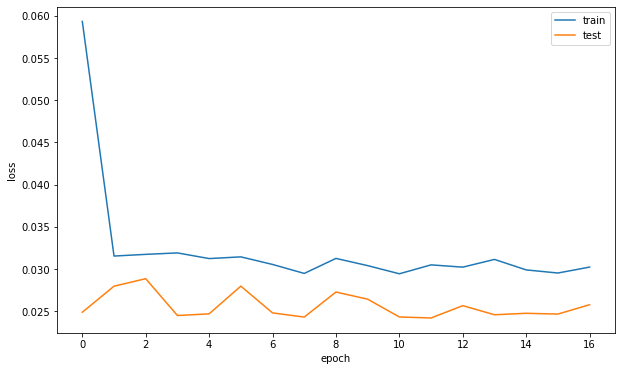

21/21 [==============================] - 2s 74ms/step
23.008399344585733 21.471781571313308


In [60]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

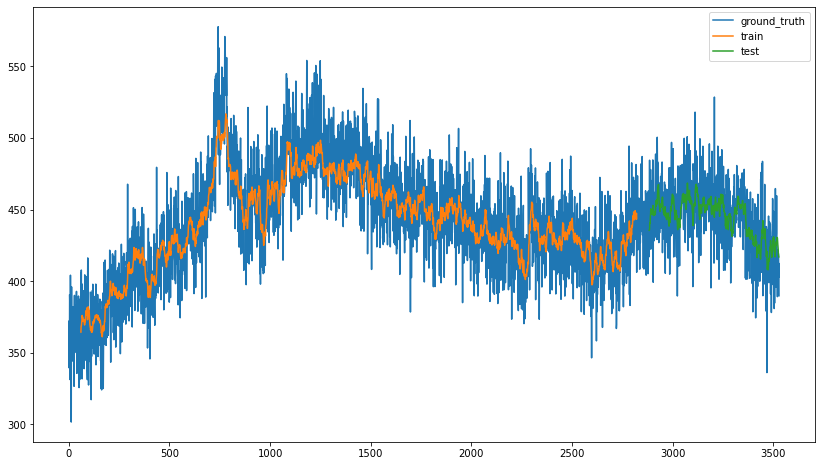

In [61]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

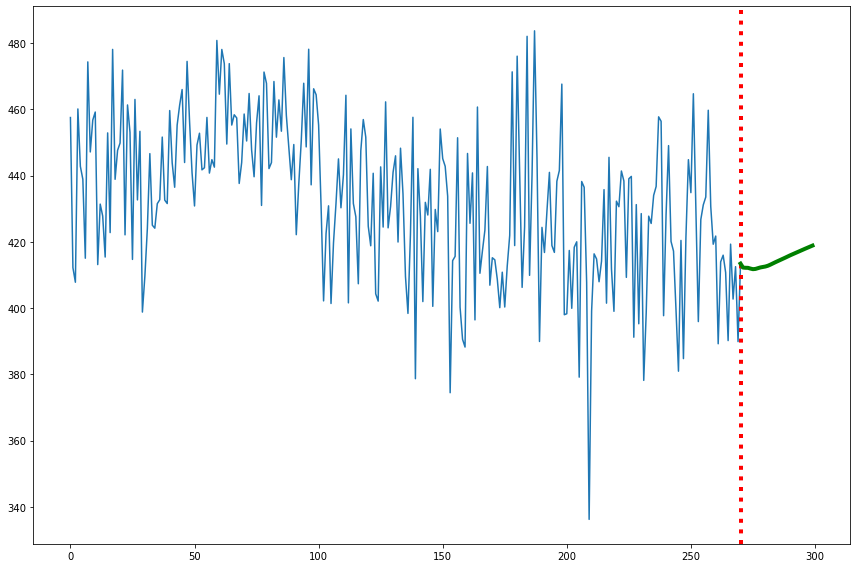

In [62]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### United Utopia Energy Corporation Stock analysis

In [63]:
stock_id = 4

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')

        Date     Open     High      Low    Close
0 2043-01-01  3949.15  3609.20  3983.82  4063.98
1 2043-01-02  3802.55  3889.22  4089.16  4200.48
2 2043-01-03  3523.31  3459.36  3975.22  3907.87
3 2043-01-06  3932.79  2859.03  3532.15  3708.79
4 2043-01-07  4043.10  3851.57  3280.59  3781.73
United Utopia Energy Corporation stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

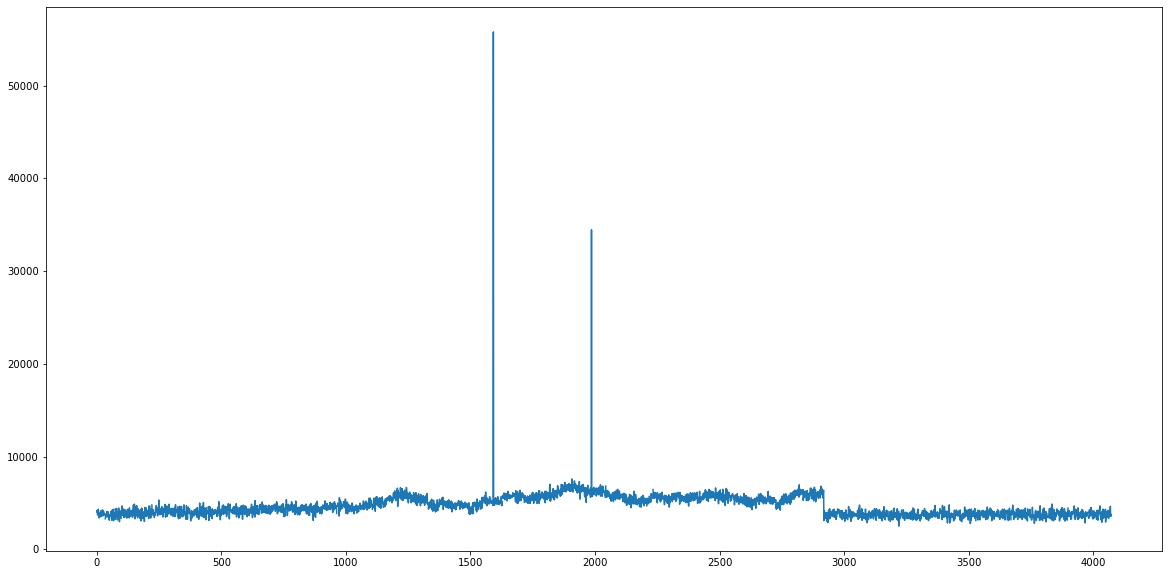

In [64]:
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are outliers in **United Utopia Energy Corporation** stock & needs to filter the same


2509.96 || 3553.9350000000004 || 55778.088968940014 || 7796.281907116612


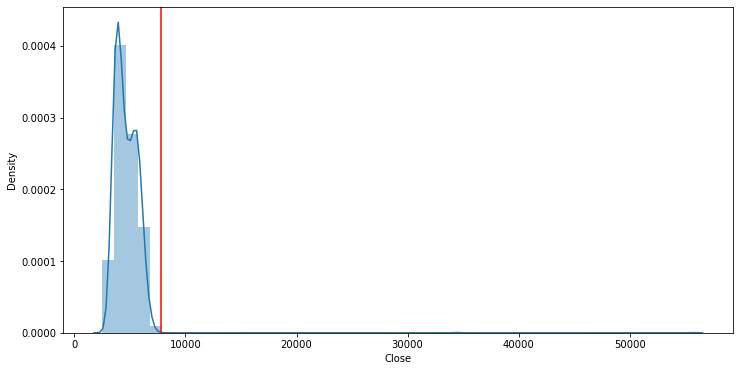

In [65]:
print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9995))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9995), color='red')

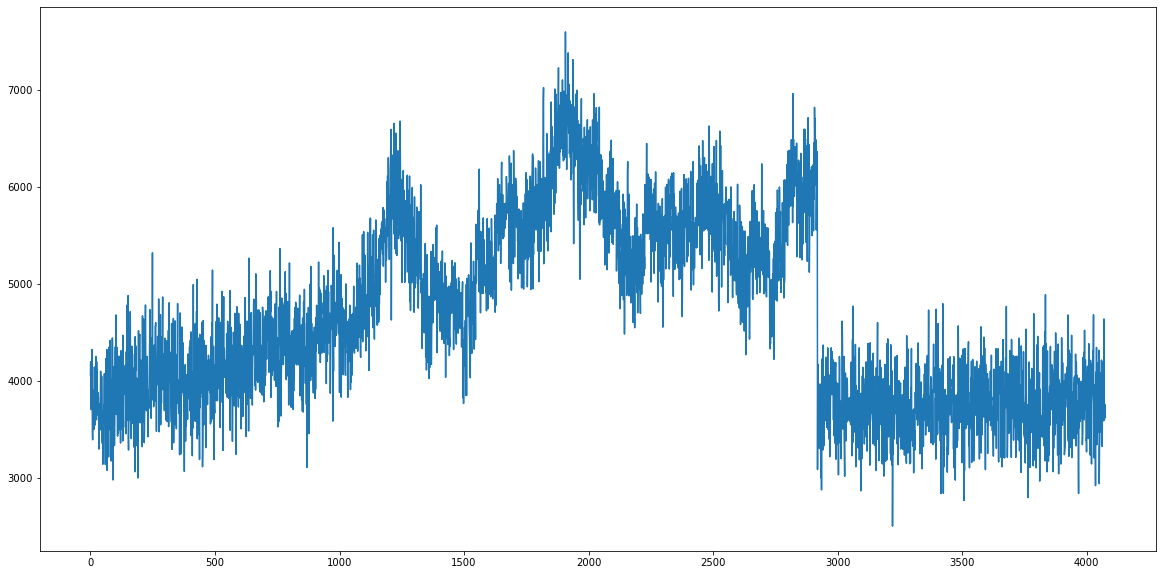

In [66]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9995)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [67]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    4063.98
1    4200.48
2    3907.87
3    3708.79
4    3781.73
Name: Close, dtype: float64


0

- There is no Null Data

Now preprocess the data & split the data into train & test

In [68]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()

Training_size : 3187, Test_size : 797 
(3187, 1) (797, 1)
(3126, 60) (3126,)
(736, 60) (736,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_13 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                          

In [69]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0702
Epoch 1: val_loss improved from inf to 0.02365, saving model to United Utopia Energy Corporation_model.h5
49/49 [==============================] - 40s 710ms/step - loss: 0.0702 - val_loss: 0.0236
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0246
Epoch 2: val_loss improved from 0.02365 to 0.02326, saving model to United Utopia Energy Corporation_model.h5
49/49 [==============================] - 35s 721ms/step - loss: 0.0246 - val_loss: 0.0233
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0263
Epoch 3: val_loss improved from 0.02326 to 0.02254, saving model to United Utopia Energy Corporation_model.h5
49/49 [==============================] - 35s 720ms/step - loss: 0.0263 - val_loss: 0.0225
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0259
Epoch 4: val_loss improved from 0.02254 to 0.02117, saving model to United Utopia Energy Corporation

In [70]:
f'{stocks[stock_id]}_model.h5'

'United Utopia Energy Corporation_model.h5'

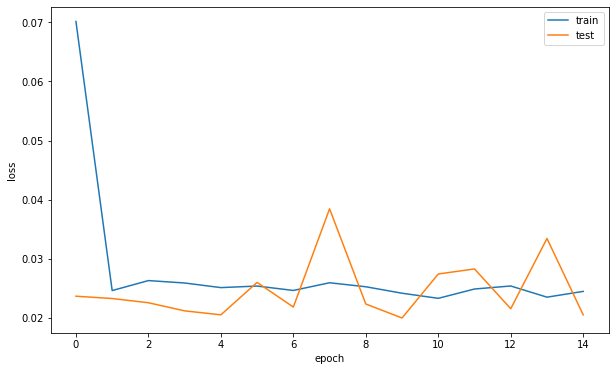

23/23 [==============================] - 2s 102ms/step
372.5192850944949 359.2222312729508


In [71]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

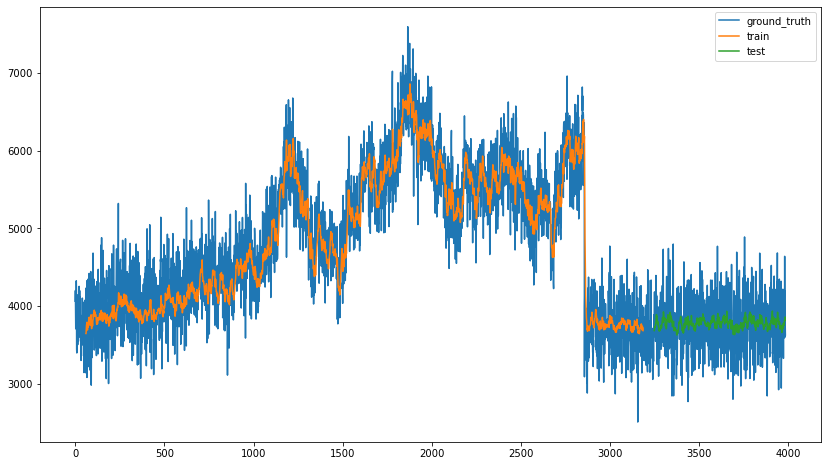

In [72]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

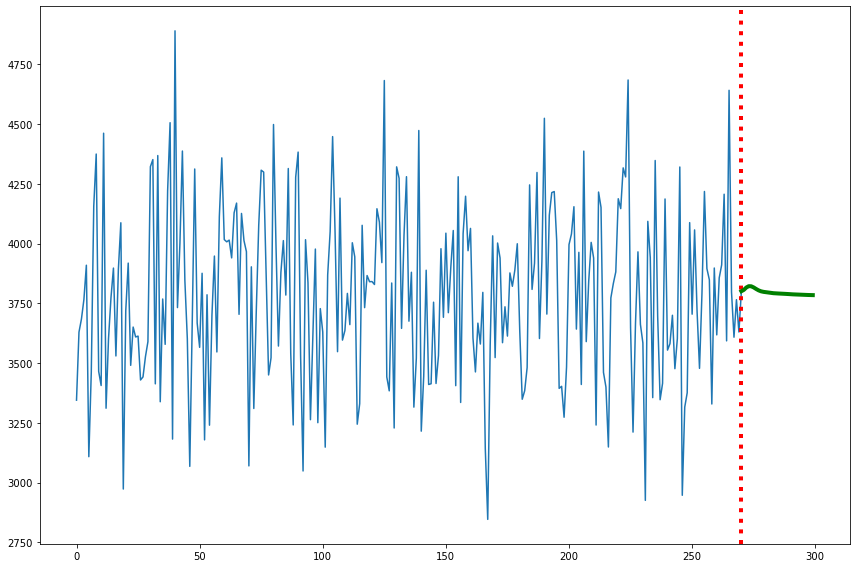

In [73]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopia Energy Stock Analysis

        Date     Open     High      Low    Close
0 2043-01-01  1742.21  1972.84  1808.10  1872.08
1 2043-01-02  2095.22  2274.97  2026.67  2031.47
2 2043-01-03  2010.54  1681.82  2151.00  1721.54
3 2043-01-06  1883.57  1973.06  1637.16  1768.27
4 2043-01-07  2147.73  1757.23  1902.86  1723.07
Utopia Energy stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

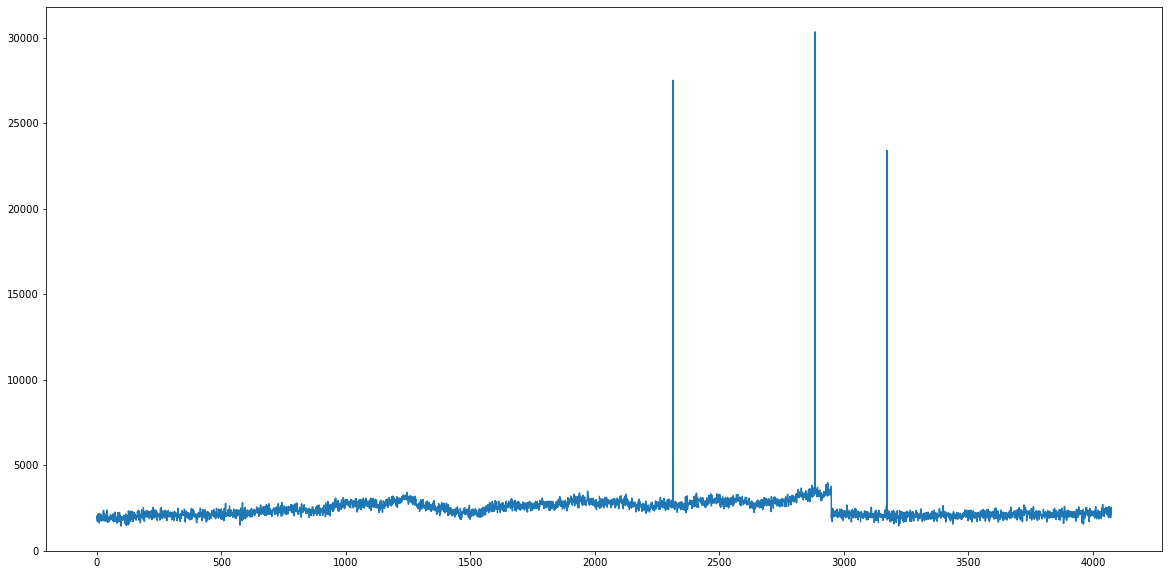

In [81]:
stock_id = 5

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))



Observed that there are outliers in **Utopia Energy** stock & needs to filter the data


1430.27 || 1950.082 || 30347.8108921544 || 3993.892111777533


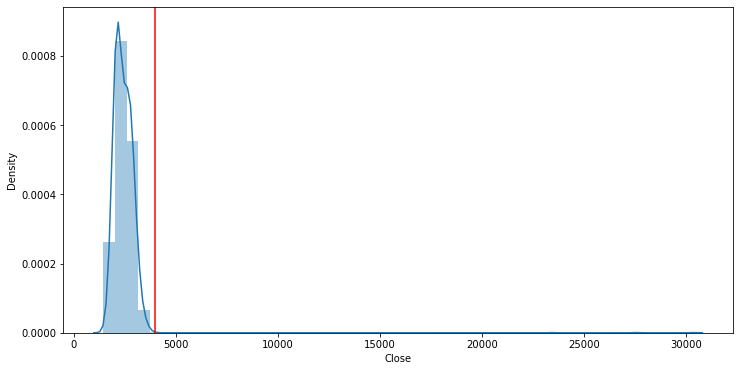

In [84]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.99925))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.99925), color='red')


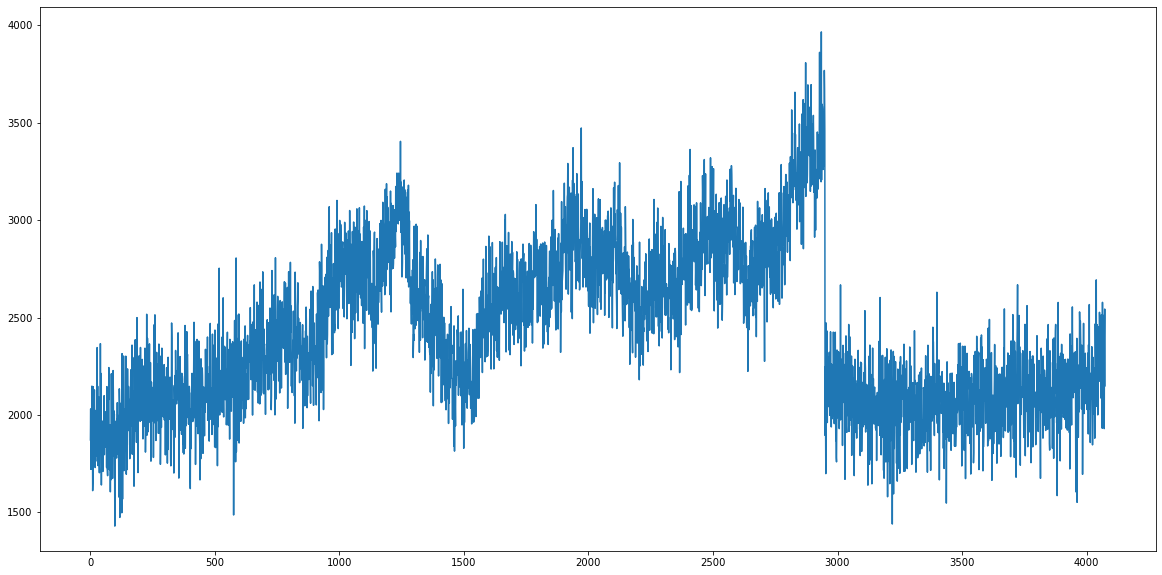

In [85]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.99925)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [86]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1872.08
1    2031.47
2    1721.54
3    1768.27
4    1723.07
Name: Close, dtype: float64


0

- There is no Null Data

Now preprocess the data & split the data into train & test

In [87]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3196, Test_size : 800 
(3196, 1) (800, 1)
(3135, 60) (3135,)
(739, 60) (739,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_16 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                          

In [91]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.4313
Epoch 1: val_loss improved from inf to 0.02750, saving model to Utopia Energy_model.h5
49/49 [==============================] - 47s 868ms/step - loss: 0.4313 - val_loss: 0.0275
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0272
Epoch 2: val_loss improved from 0.02750 to 0.02320, saving model to Utopia Energy_model.h5
49/49 [==============================] - 43s 874ms/step - loss: 0.0272 - val_loss: 0.0232
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0266
Epoch 3: val_loss did not improve from 0.02320
49/49 [==============================] - 43s 886ms/step - loss: 0.0266 - val_loss: 0.0259
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0264
Epoch 4: val_loss did not improve from 0.02320
49/49 [==============================] - 44s 903ms/step - loss: 0.0264 - val_loss: 0.0237
Epoch 5/100
49/49 [==============================] - ETA: 0s - l

In [92]:
f'{stocks[stock_id]}_model.h5'

'Utopia Energy_model.h5'

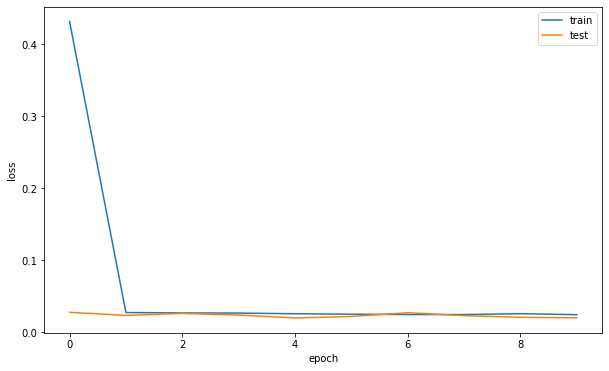

24/24 [==============================] - 3s 125ms/step
188.35847348213372 177.50304098642206


In [93]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

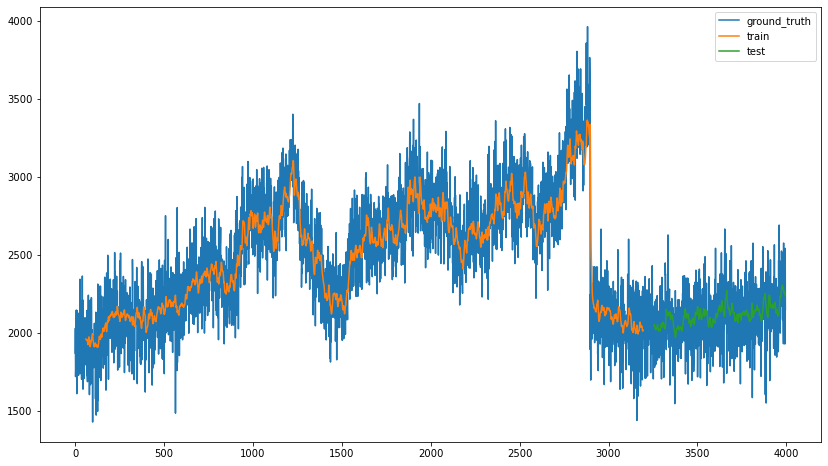

In [94]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

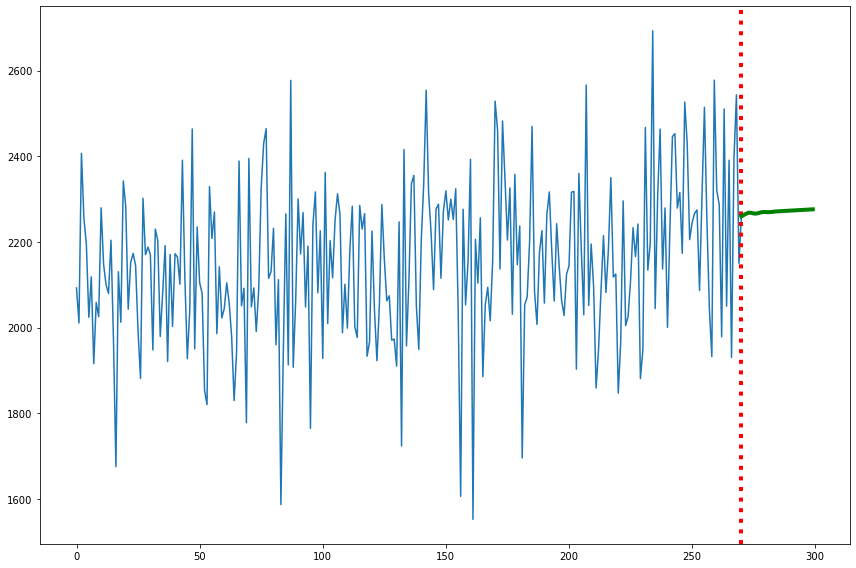

In [95]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopia General Power Stock Analysis

        Date      Open      High       Low     Close
0 2043-01-01  10874.39  11969.98  10111.46  13833.45
1 2043-01-02  11503.97   9195.10  13331.01  10623.93
2 2043-01-03  11563.76  12958.24  13278.24       NaN
3 2043-01-06  12362.30  13412.98  12719.11  11784.13
4 2043-01-07   9870.33   9755.68       NaN  12562.32
Utopia General Power stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

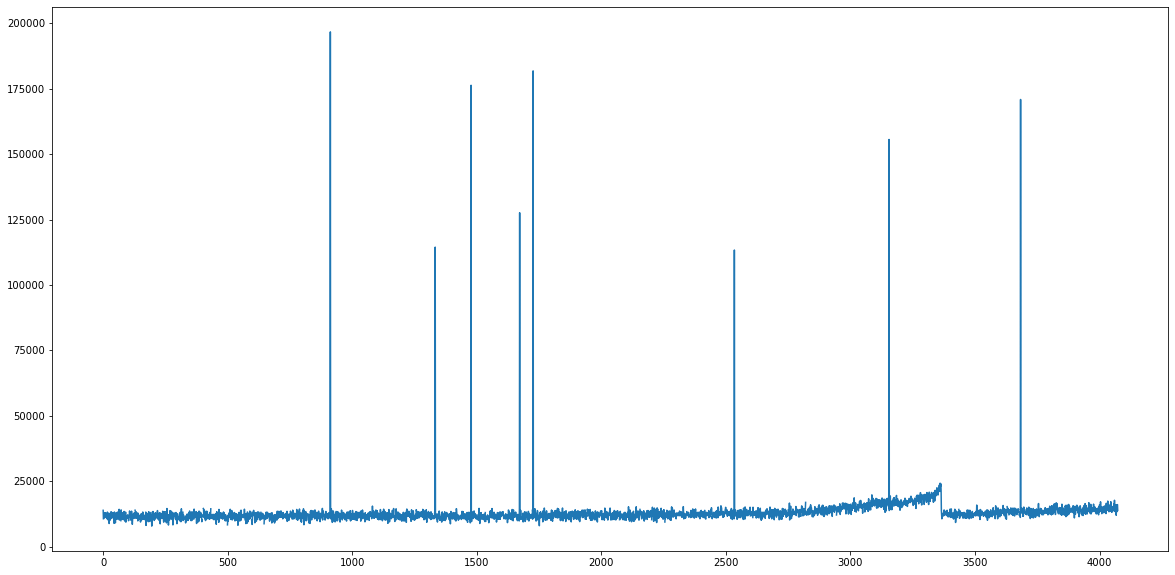

In [98]:
stock_id = 6

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))

Observed that there are outliers in **Utopia General Power** stock & needs to filter the data

7807.0 || 10588.316 || 196766.696942168 || 25290.839901441053


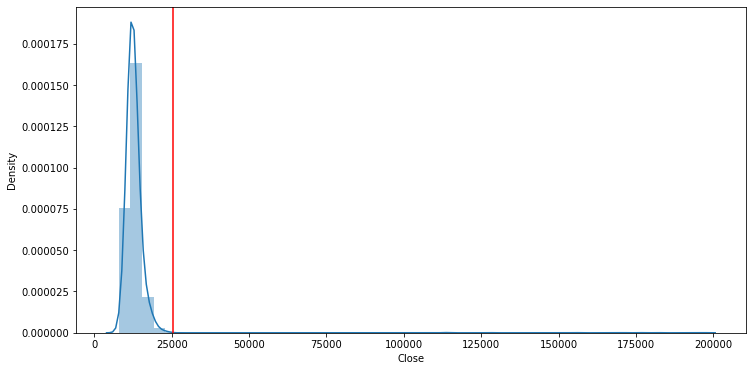

In [108]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.998))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.998), color='red')


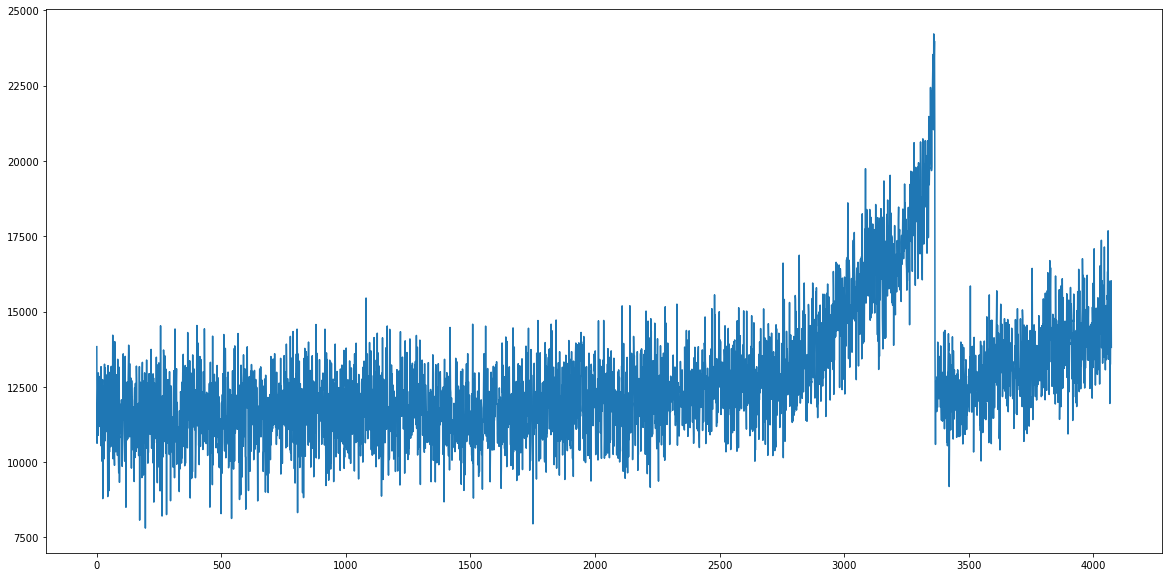

In [109]:

# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.998)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()


In [110]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()


0    13833.45
1    10623.93
2    11784.13
3    12562.32
4    10887.20
Name: Close, dtype: float64


0

- There is no Null Data

Now preprocess the data & split the data into train & test


In [111]:
# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3189, Test_size : 798 
(3189, 1) (798, 1)
(3128, 60) (3128,)
(737, 60) (737,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_19 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                          

In [112]:

history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.3016
Epoch 1: val_loss improved from inf to 0.03552, saving model to Utopia General Power_model.h5
49/49 [==============================] - 53s 977ms/step - loss: 1.3016 - val_loss: 0.0355
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0283
Epoch 2: val_loss did not improve from 0.03552
49/49 [==============================] - 49s 993ms/step - loss: 0.0283 - val_loss: 0.0386
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0270
Epoch 3: val_loss did not improve from 0.03552
49/49 [==============================] - 49s 995ms/step - loss: 0.0270 - val_loss: 0.0382
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0256
Epoch 4: val_loss improved from 0.03552 to 0.03353, saving model to Utopia General Power_model.h5
49/49 [==============================] - 50s 1s/step - loss: 0.0256 - val_loss: 0.0335
Epoch 5/100
49/49 [==============================] - 

In [113]:
f'{stocks[stock_id]}_model.h5'

'Utopia General Power_model.h5'

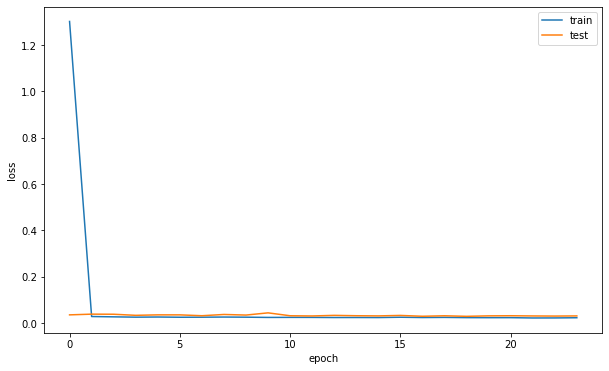

24/24 [==============================] - 3s 106ms/step
1221.819263237237 1402.6423163883633


In [114]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

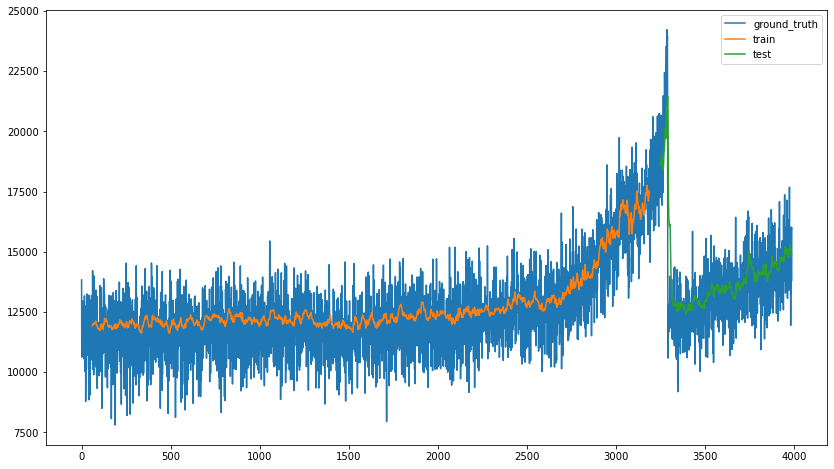

In [115]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

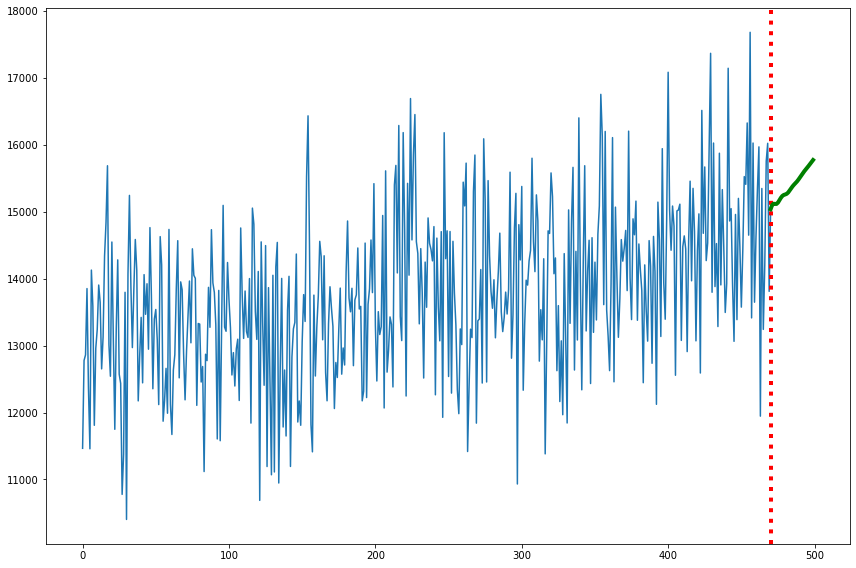

In [117]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 500)

### Utopia Oil and Gas Stock Analysis

        Date     Open     High      Low    Close
0 2043-01-01  3035.17  2543.20  2850.68  2841.84
1 2043-01-02  2652.49  3021.46  2865.50  2766.34
2 2043-01-03  2631.92  2747.53  2849.37  2374.05
3 2043-01-06  2703.74  2718.00  2602.74  3039.49
4 2043-01-07  2530.33  2716.89  2999.40  2600.80
Utopia Oil and Gas stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

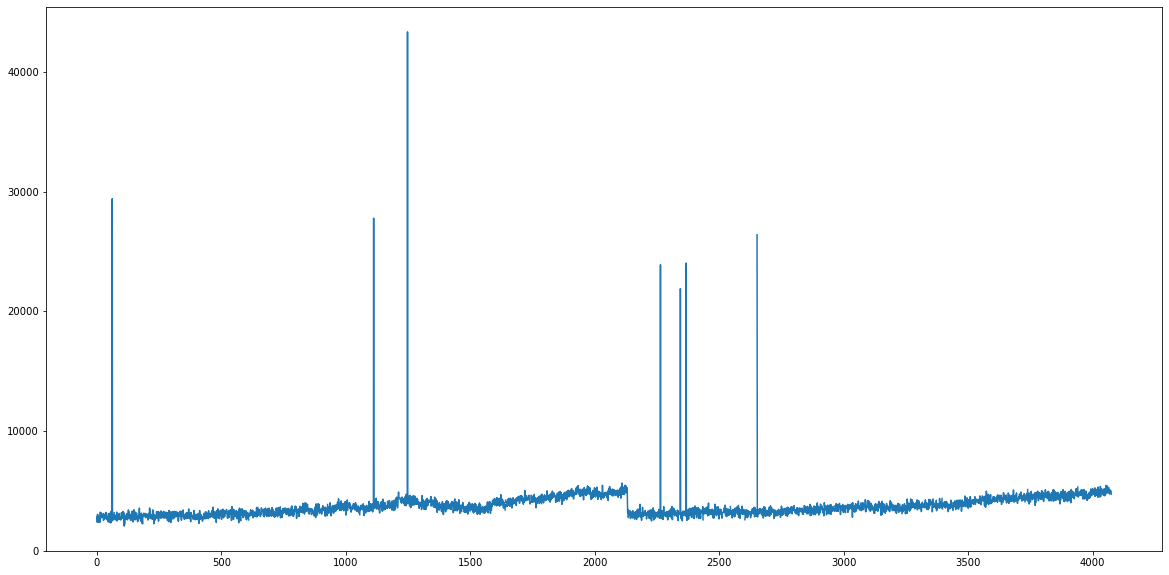

In [118]:
stock_id = 7

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are outliers in **Utopia Oil and Gas** stock & needs to filter the data


2054.31 || 2884.336 || 43351.21149738258 || 5614.215479999963


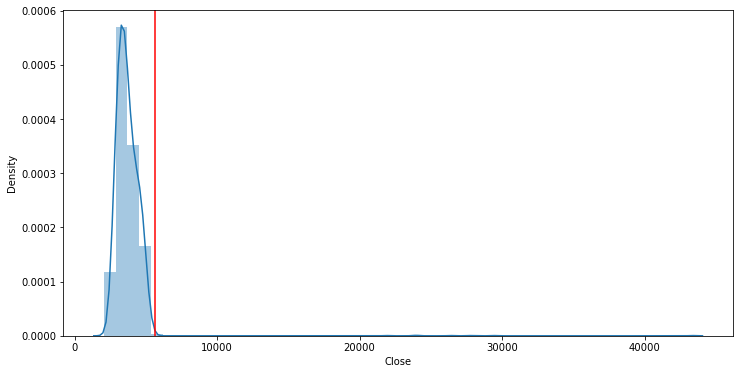

In [125]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9982))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9982), color='red')

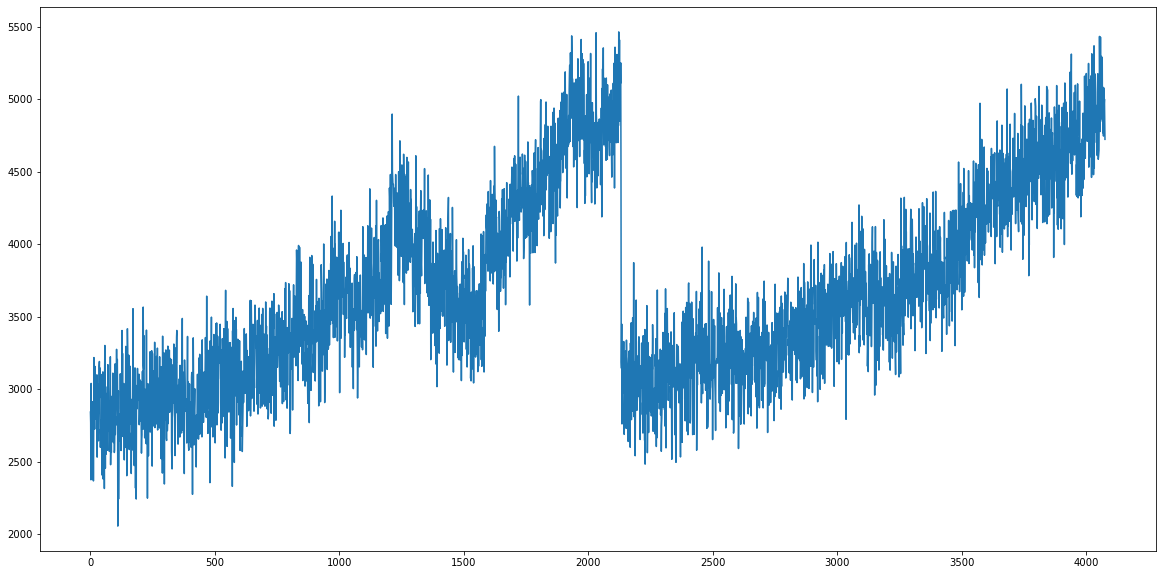

In [126]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9982)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [127]:

df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()


0    2841.84
1    2766.34
2    2374.05
3    3039.49
4    2600.80
Name: Close, dtype: float64


0


- There is no Null Data

Now preprocess the data & split the data into train & test


In [128]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()

Training_size : 3177, Test_size : 795 
(3177, 1) (795, 1)
(3116, 60) (3116,)
(734, 60) (734,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_22 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                          

In [129]:

history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0604
Epoch 1: val_loss improved from inf to 0.02278, saving model to Utopia Oil and Gas_model.h5
49/49 [==============================] - 56s 1s/step - loss: 0.0604 - val_loss: 0.0228
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0303
Epoch 2: val_loss improved from 0.02278 to 0.02255, saving model to Utopia Oil and Gas_model.h5
49/49 [==============================] - 52s 1s/step - loss: 0.0303 - val_loss: 0.0226
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0288
Epoch 3: val_loss improved from 0.02255 to 0.02159, saving model to Utopia Oil and Gas_model.h5
49/49 [==============================] - 52s 1s/step - loss: 0.0288 - val_loss: 0.0216
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0279
Epoch 4: val_loss did not improve from 0.02159
49/49 [==============================] - 55s 1s/step - loss: 0.0279 - val_loss: 0.0351
Epoch 5/100
49/49

In [130]:
f'{stocks[stock_id]}_model.h5'

'Utopia Oil and Gas_model.h5'

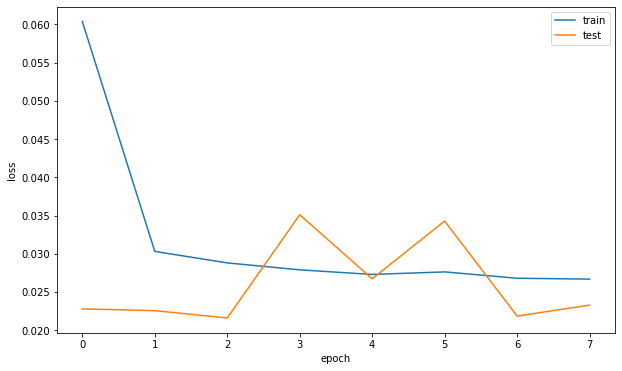

23/23 [==============================] - 3s 127ms/step
274.38033451227597 250.68448952927903


In [131]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

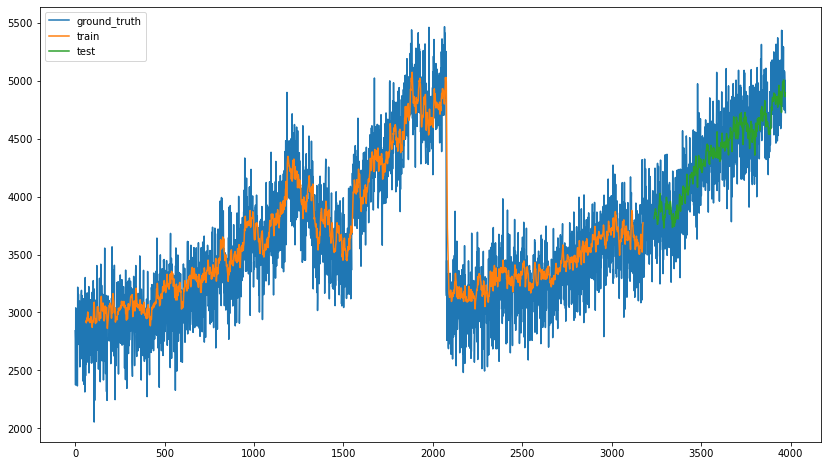

In [132]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

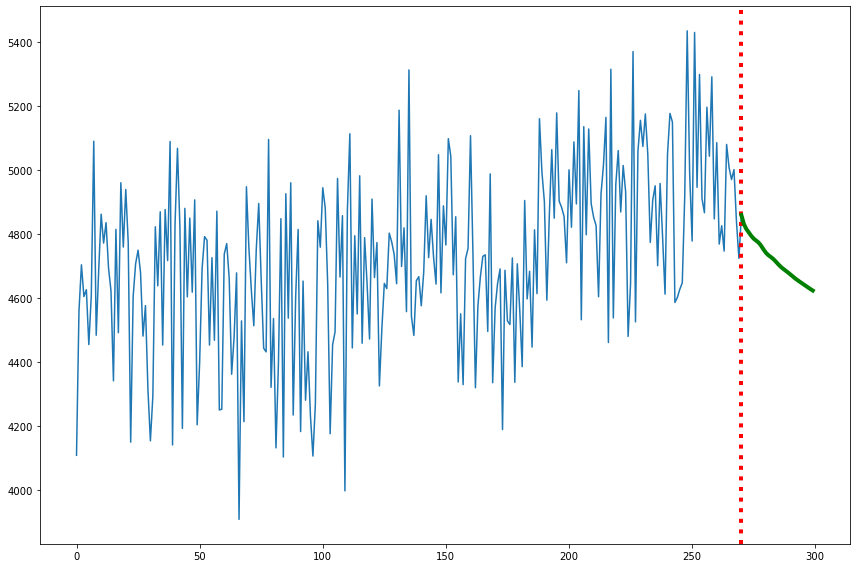

In [133]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopia Petroleums Stock Analysis

        Date     Open     High      Low    Close
0 2043-01-01  1887.44  2043.69  2033.80  1935.04
1 2043-01-02  2079.12  1740.48  1805.00  1902.65
2 2043-01-03  2433.81  2307.76  2216.60  1670.89
3 2043-01-06  1979.08  2205.99  2157.57  1965.09
4 2043-01-07  2189.10  2177.64  1882.33  1921.98
Utopia Petroleums stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

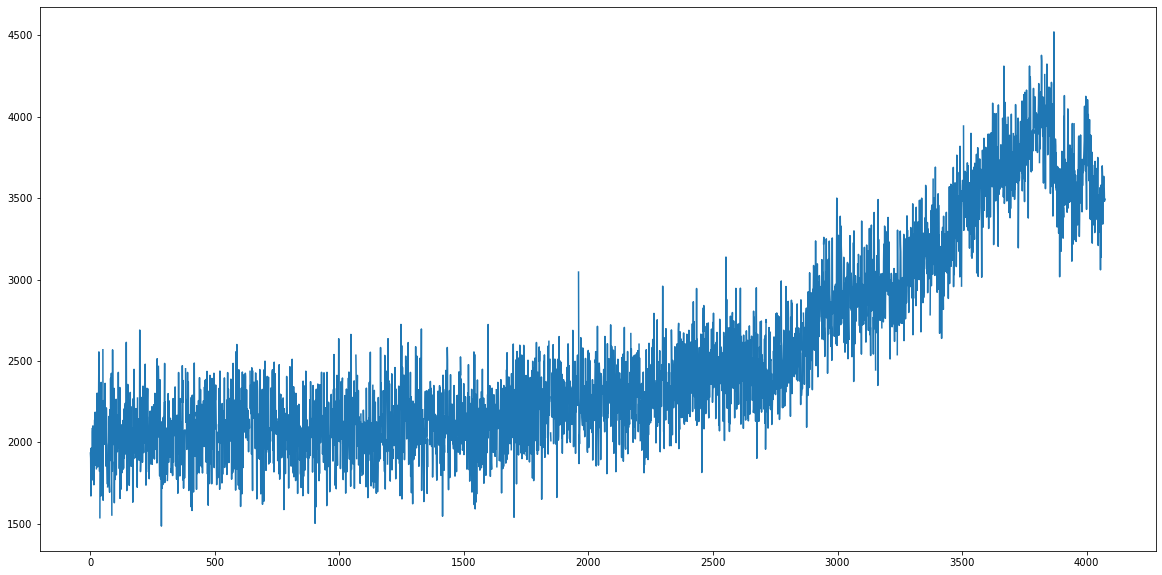

In [134]:
stock_id = 8

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are no outliers in **Utopia Petroleums ** stock & no needs to filter the data


1486.06 || 1926.755 || 4521.88 || 4213.701000000006


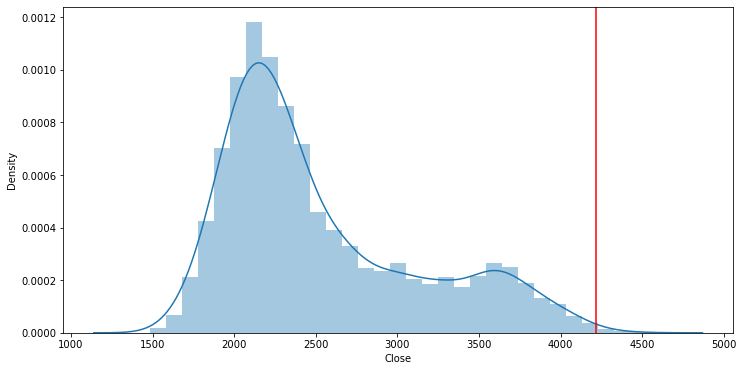

In [135]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.998))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.998), color='red')

In [ ]:

# # removing the outliers
# val = stocks_df[stock_id]['Close'].quantile(0.998)
# stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
# stocks_df[stock_id]['Close'].plot(figsize=(20,10))
# plt.show()


In [136]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1935.04
1    1902.65
2    1670.89
3    1965.09
4    1921.98
Name: Close, dtype: float64


99


There are 99 Null Data points and will drop those data points for further assesment


In [138]:
df.dropna(inplace=True)
df.isnull().sum()

0


Now preprocess the data & split the data into train & test


In [139]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3180, Test_size : 796 
(3180, 1) (796, 1)
(3119, 60) (3119,)
(735, 60) (735,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_25 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_26 (LSTM)              (None, 128)               131584    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                          

In [140]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.1459
Epoch 1: val_loss improved from inf to 0.02790, saving model to Utopia Petroleums_model.h5
49/49 [==============================] - 57s 1s/step - loss: 0.1459 - val_loss: 0.0279
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0249
Epoch 2: val_loss improved from 0.02790 to 0.02596, saving model to Utopia Petroleums_model.h5
49/49 [==============================] - 58s 1s/step - loss: 0.0249 - val_loss: 0.0260
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0232
Epoch 3: val_loss did not improve from 0.02596
49/49 [==============================] - 58s 1s/step - loss: 0.0232 - val_loss: 0.0434
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0227
Epoch 4: val_loss improved from 0.02596 to 0.02166, saving model to Utopia Petroleums_model.h5
49/49 [==============================] - 59s 1s/step - loss: 0.0227 - val_loss: 0.0217
Epoch 5/100
49/49 [=

In [141]:
f'{stocks[stock_id]}_model.h5'

'Utopia Petroleums_model.h5'

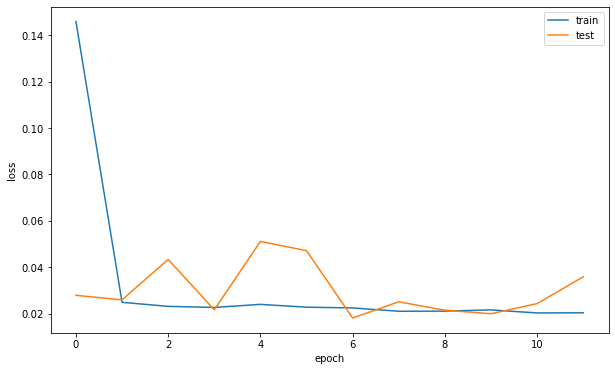

23/23 [==============================] - 3s 145ms/step
205.60195006308643 204.4563650377334


In [142]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)


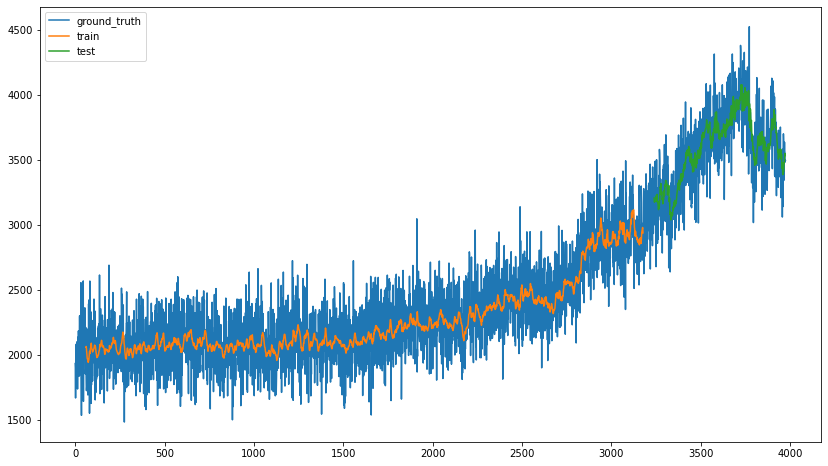

In [143]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)


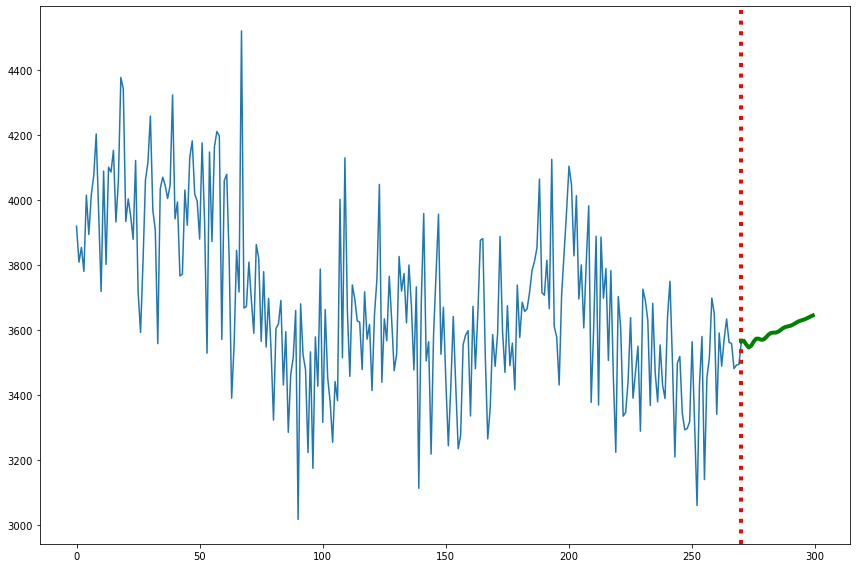

In [144]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopia Power Solutions Stock Analysis

In [167]:
stock_id = 9

        Date     Open     High      Low    Close
0 2043-01-01  2206.86  1655.76  2022.12  2324.22
1 2043-01-02  1773.98  1907.09  2188.80  2302.97
2 2043-01-03  1762.05  1727.67  2068.65  2270.24
3 2043-01-06  2410.04  1900.70  2153.49  2056.69
4 2043-01-07  1998.88  1811.76  2168.63  1981.73
Utopia Power Solutions stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

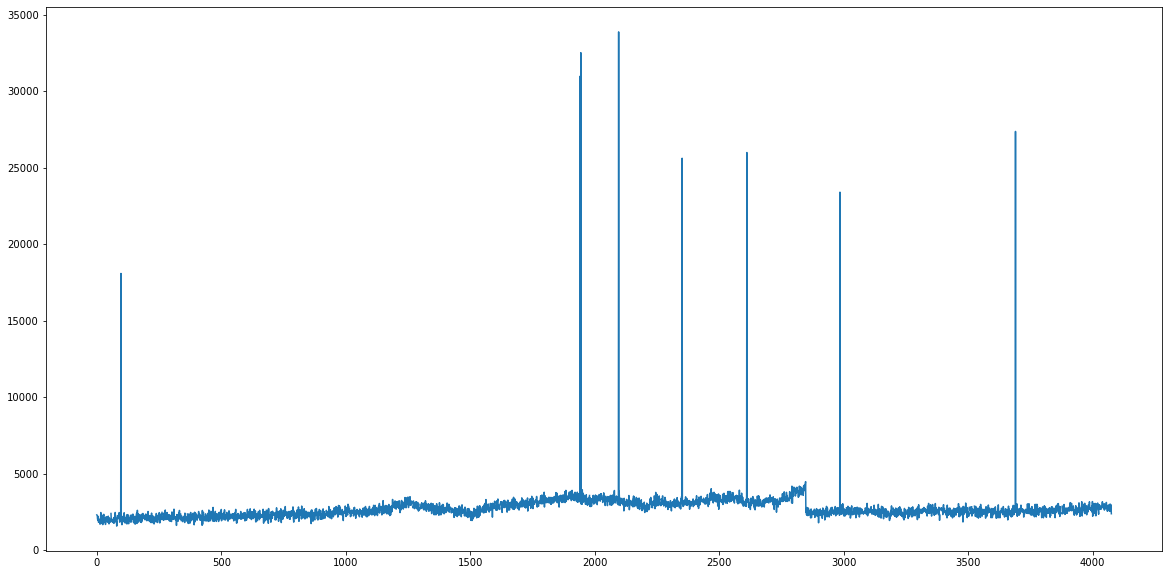

In [145]:


print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are outliers in **Utopia Power Solutions** stock & needs to filter the data

1591.54 || 2145.046 || 33879.81906986774 || 4494.824680000014


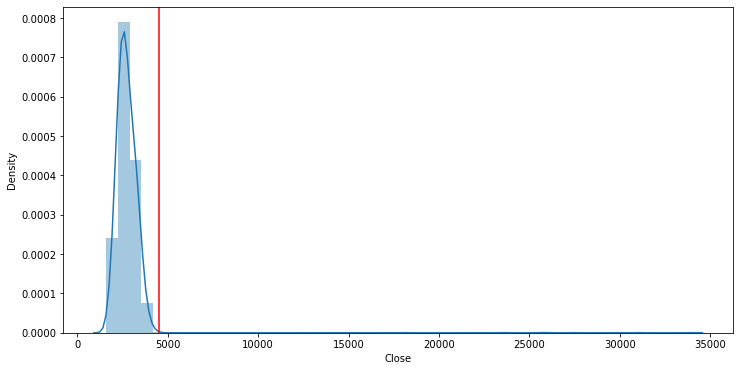

In [149]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.998))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.998), color='red')

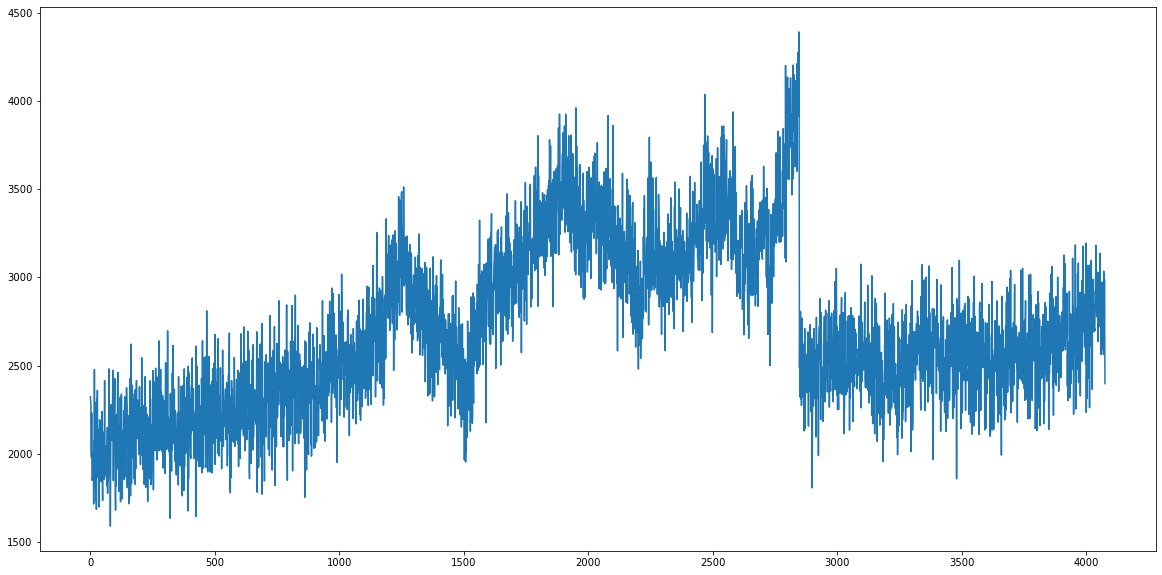

In [150]:

# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.998)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [151]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    2324.22
1    2302.97
2    2270.24
3    2056.69
4    1981.73
Name: Close, dtype: float64


0

- There is no Null Data

Now preprocess the data & split the data into train & test

In [152]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3196, Test_size : 799 
(3196, 1) (799, 1)
(3135, 60) (3135,)
(738, 60) (738,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_28 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_29 (LSTM)              (None, 128)               131584    
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                          

In [158]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0777
Epoch 1: val_loss improved from inf to 0.02276, saving model to Utopia Power Solutions_model.h5
49/49 [==============================] - 60s 1s/step - loss: 0.0777 - val_loss: 0.0228
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0284
Epoch 2: val_loss did not improve from 0.02276
49/49 [==============================] - 52s 1s/step - loss: 0.0284 - val_loss: 0.0245
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0269
Epoch 3: val_loss did not improve from 0.02276
49/49 [==============================] - 54s 1s/step - loss: 0.0269 - val_loss: 0.0228
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0261
Epoch 4: val_loss improved from 0.02276 to 0.02226, saving model to Utopia Power Solutions_model.h5
49/49 [==============================] - 53s 1s/step - loss: 0.0261 - val_loss: 0.0223
Epoch 5/100
49/49 [==============================] - ETA: 

In [168]:
f'{stocks[stock_id]}_model.h5'

'Utopia Power Solutions_model.h5'

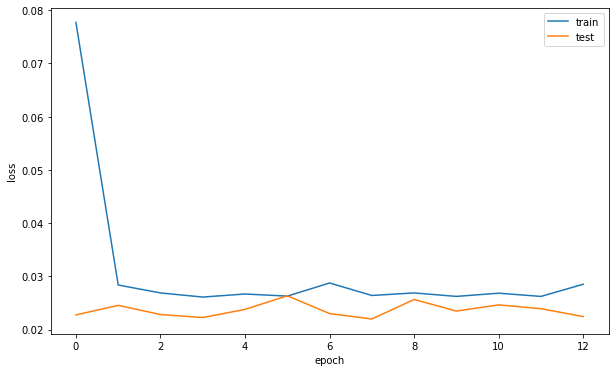

24/24 [==============================] - 2s 101ms/step
223.4647228438156 207.58623387720903


In [169]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

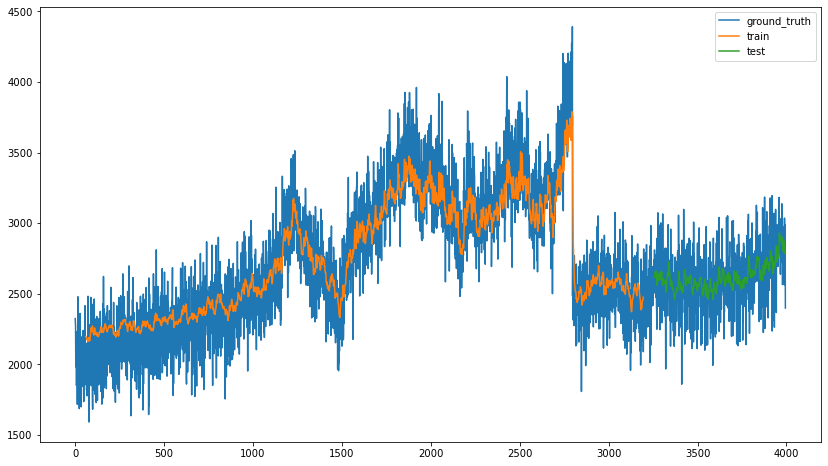

In [170]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

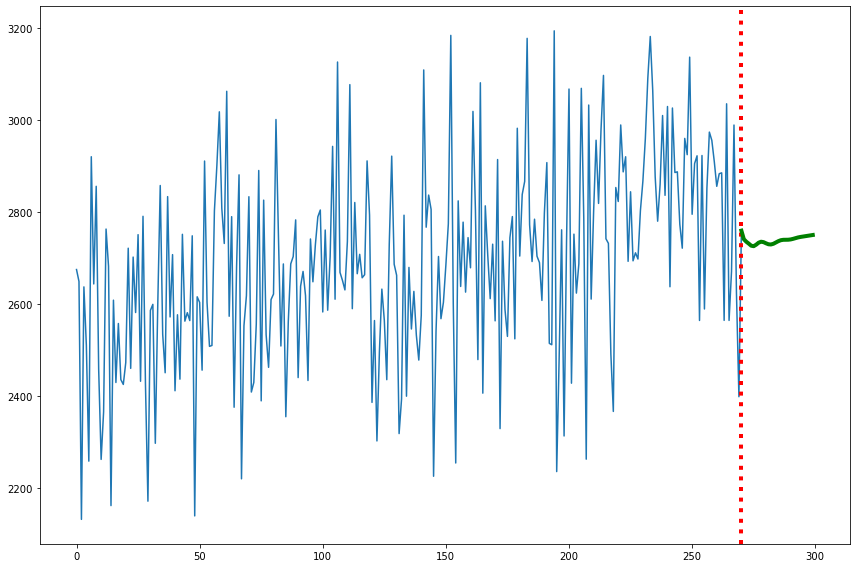

In [171]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopia Sublime Bank Group Stock Analysis

        Date    Open    High     Low   Close
0 2043-01-01  603.23  655.12  609.57  575.76
1 2043-01-02  765.08  565.14  590.23  656.34
2 2043-01-03  598.19  559.82  633.41  639.92
3 2043-01-06  641.44  634.57  638.60  609.34
4 2043-01-07  626.65  660.70  530.87  712.53
Utopia Sublime Bank Group stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

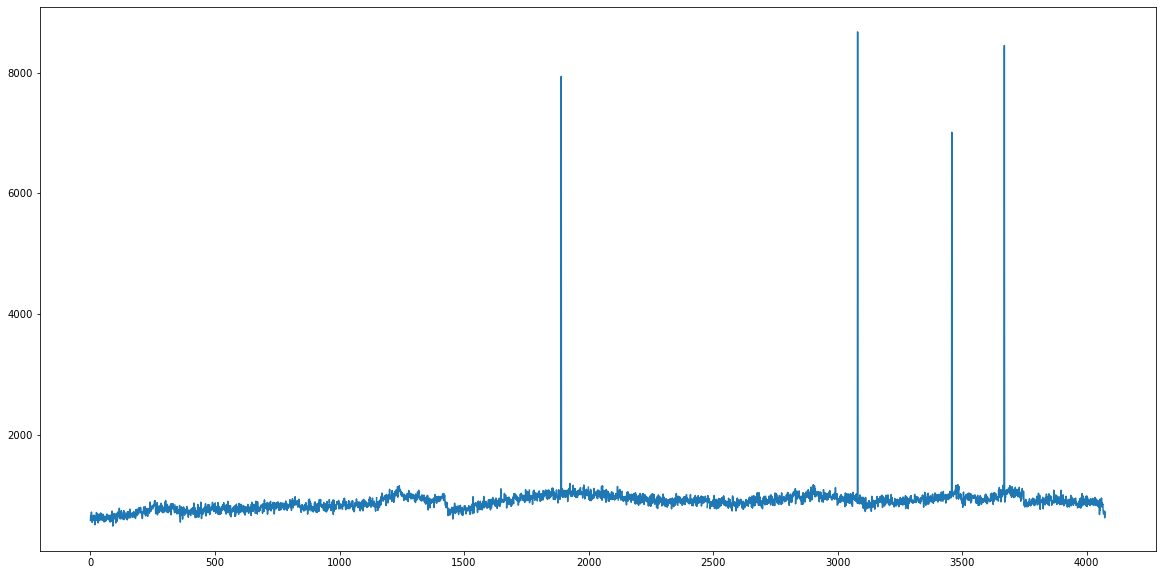

In [176]:
stock_id = 10

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))



Observed that there are outliers in **Utopia Sublime Bank Group** stock & needs to filter the data


481.02 || 729.74 || 8678.006575750689 || 1246.1449319236967


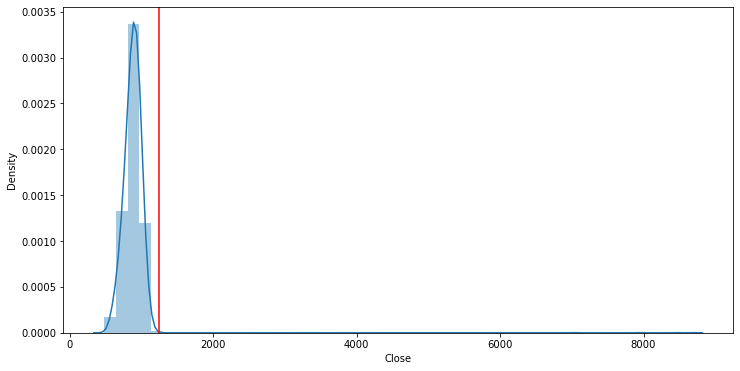

In [181]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.999))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.999), color='red')

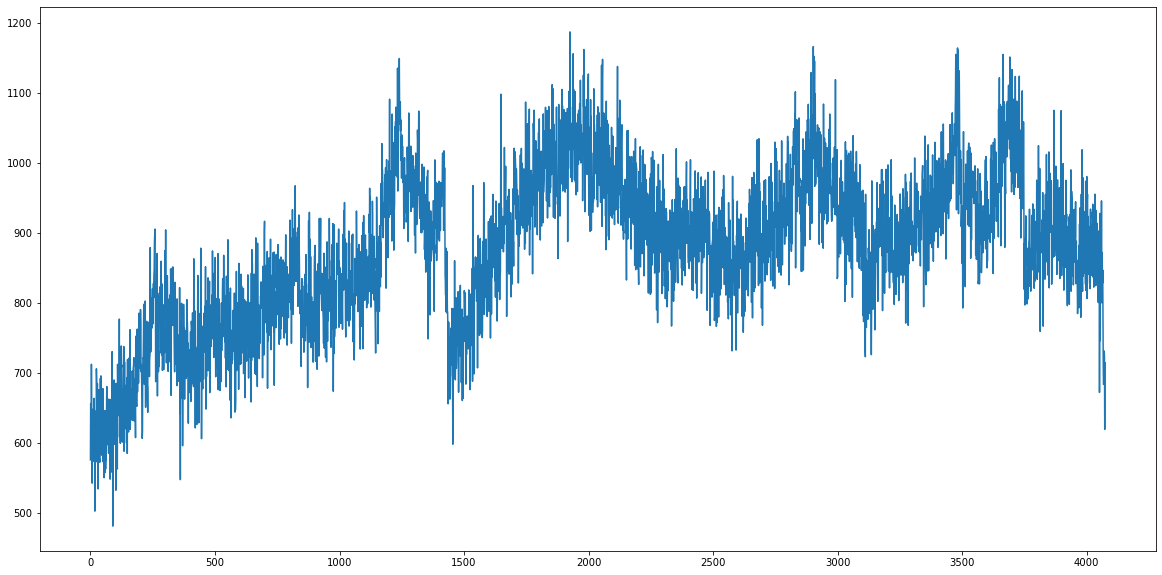

In [182]:
# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.999)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()


In [184]:
df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    575.76
1    656.34
2    639.92
3    609.34
4    712.53
Name: Close, dtype: float64


0


- There is no Null Data

Now preprocess the data & split the data into train & test


In [185]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3189, Test_size : 798 
(3189, 1) (798, 1)
(3128, 60) (3128,)
(737, 60) (737,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_31 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_32 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                         

In [186]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0551
Epoch 1: val_loss improved from inf to 0.02544, saving model to Utopia Sublime Bank Group_model.h5
49/49 [==============================] - 65s 1s/step - loss: 0.0551 - val_loss: 0.0254
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0277
Epoch 2: val_loss did not improve from 0.02544
49/49 [==============================] - 58s 1s/step - loss: 0.0277 - val_loss: 0.0264
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0272
Epoch 3: val_loss did not improve from 0.02544
49/49 [==============================] - 59s 1s/step - loss: 0.0272 - val_loss: 0.0326
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0273
Epoch 4: val_loss did not improve from 0.02544
49/49 [==============================] - 60s 1s/step - loss: 0.0273 - val_loss: 0.0310
Epoch 5/100
49/49 [==============================] - ETA: 0s - loss: 0.0264
Epoch 5: val_loss did not improv

In [187]:
f'{stocks[stock_id]}_model.h5'

'Utopia Sublime Bank Group_model.h5'

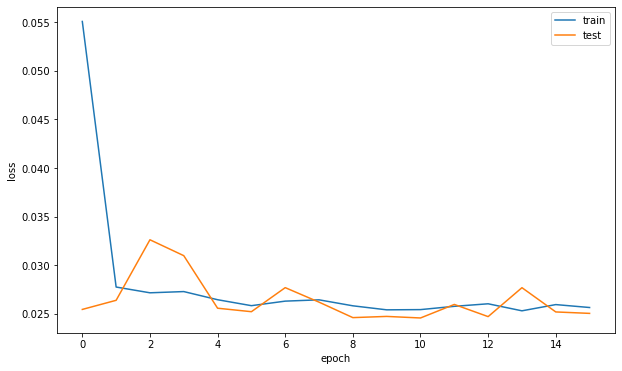

24/24 [==============================] - 3s 139ms/step
53.43013047537203 55.38942093814968


In [188]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

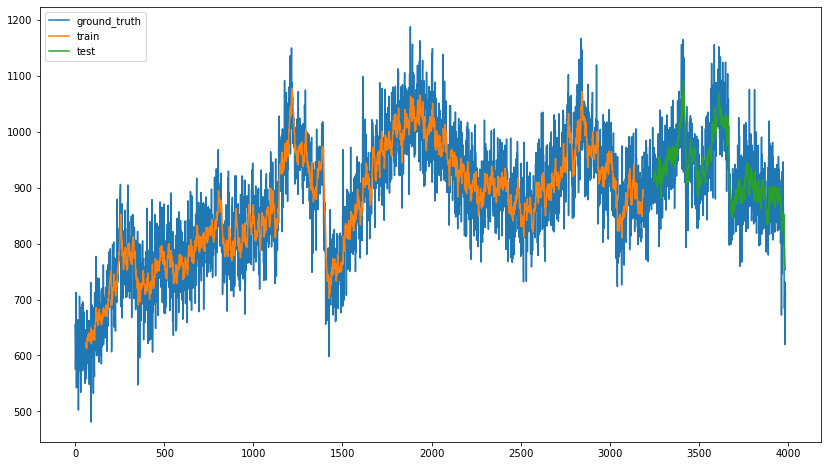

In [189]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

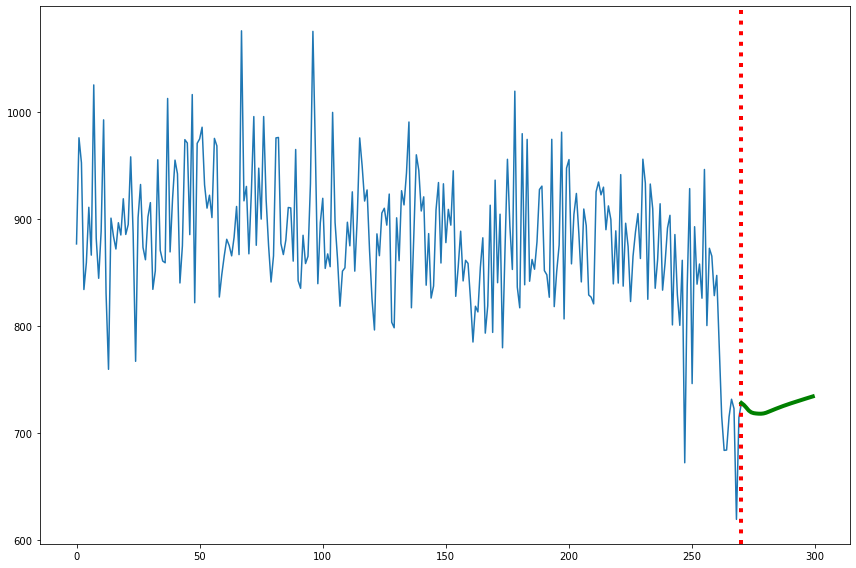

In [190]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopian Bank Stock Analysis

        Date     Open     High      Low    Close
0 2043-01-01  1102.47  1158.56   996.30  1105.04
1 2043-01-02  1184.56  1032.72  1100.05  1071.96
2 2043-01-03  1299.83  1048.07  1078.18      NaN
3 2043-01-06  1017.26  1054.60  1057.63   970.06
4 2043-01-07  1056.10  1060.90   993.95  1130.43
Utopian Bank stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

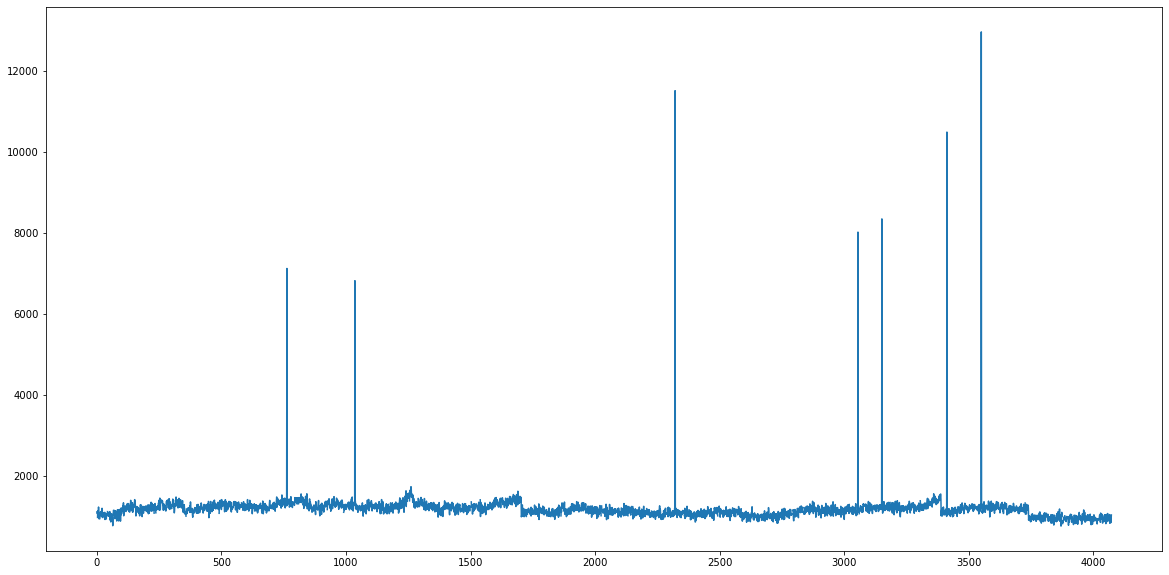

In [202]:
stock_id = 11

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are outliers in **Utopian Bank** stock & needs to filter the data


755.46 || 986.918 || 12961.537933472428 || 1723.7436759999935


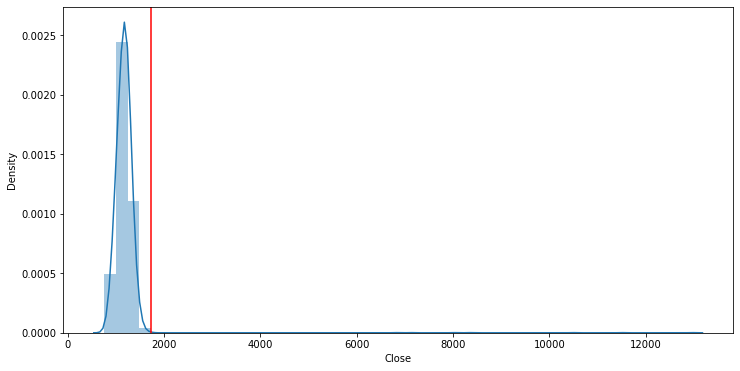

In [203]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.9982))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.9982), color='red')


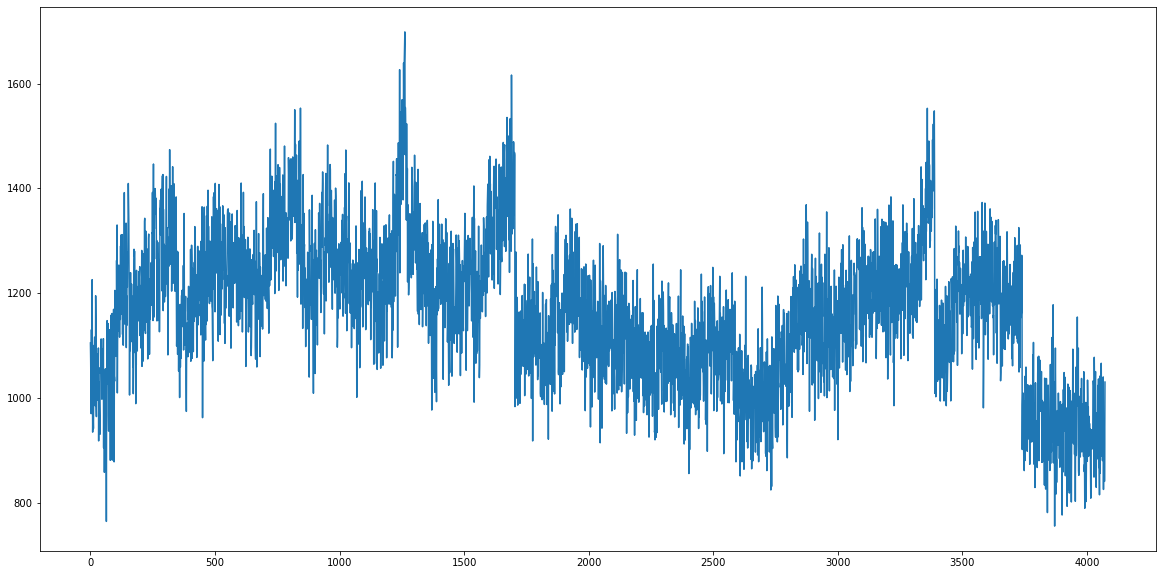

In [204]:

# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.9982)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [205]:

df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1105.04
1    1071.96
2     970.06
3    1130.43
4    1012.85
Name: Close, dtype: float64


0


- There is no Null Data

Now preprocess the data & split the data into train & test


In [206]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3180, Test_size : 795 
(3180, 1) (795, 1)
(3119, 60) (3119,)
(734, 60) (734,)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_34 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_35 (LSTM)              (None, 128)               131584    
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                         

In [207]:

history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0586
Epoch 1: val_loss improved from inf to 0.03039, saving model to Utopian Bank_model.h5
49/49 [==============================] - 67s 1s/step - loss: 0.0586 - val_loss: 0.0304
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0335
Epoch 2: val_loss did not improve from 0.03039
49/49 [==============================] - 60s 1s/step - loss: 0.0335 - val_loss: 0.0357
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0317
Epoch 3: val_loss improved from 0.03039 to 0.02933, saving model to Utopian Bank_model.h5
49/49 [==============================] - 61s 1s/step - loss: 0.0317 - val_loss: 0.0293
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0309
Epoch 4: val_loss improved from 0.02933 to 0.02763, saving model to Utopian Bank_model.h5
49/49 [==============================] - 62s 1s/step - loss: 0.0309 - val_loss: 0.0276
Epoch 5/100
49/49 [================

In [208]:
f'{stocks[stock_id]}_model.h5'

'Utopian Bank_model.h5'

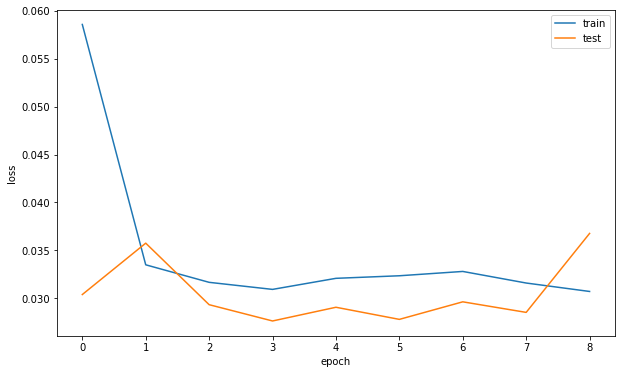

23/23 [==============================] - 3s 127ms/step
80.31293746671669 78.39747121957012


In [209]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

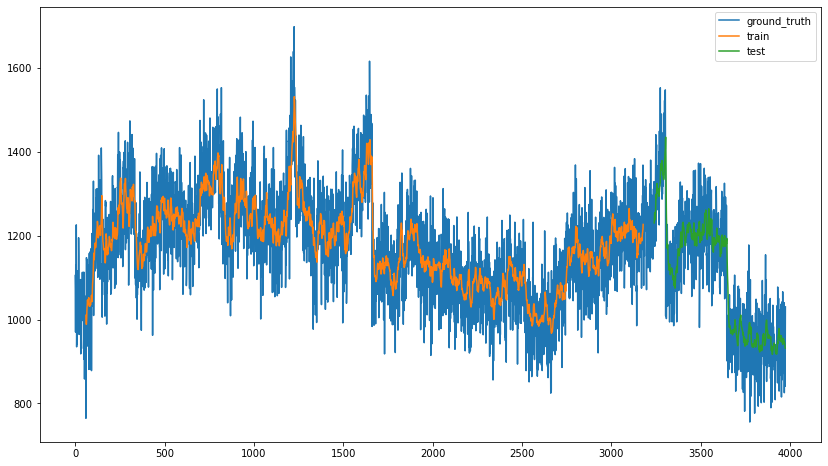

In [210]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

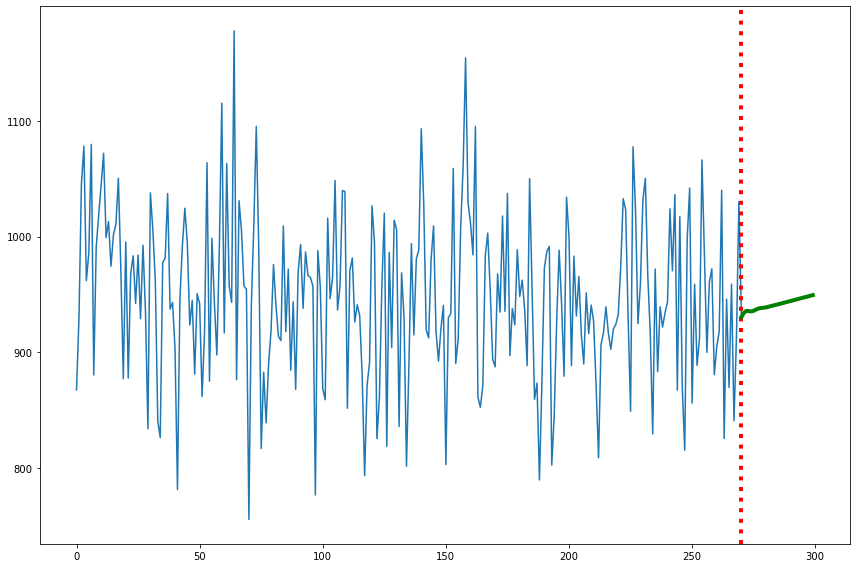

In [211]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

### Utopian Financial Services Stock Analysis

        Date     Open     High      Low    Close
0 2043-01-01  1301.59  1380.33  1395.44  1346.45
1 2043-01-02  1218.33  1345.65  1269.73  1284.22
2 2043-01-03  1425.36  1267.08  1351.12  1341.98
3 2043-01-06  1285.74  1374.98  1337.03  1500.73
4 2043-01-07  1310.99  1464.14  1449.98  1513.98
Utopian Financial Services stock prices between 2043-01-01 00:00:00 and 2059-07-19 00:00:00
Total trading Days = 6043


<AxesSubplot:>

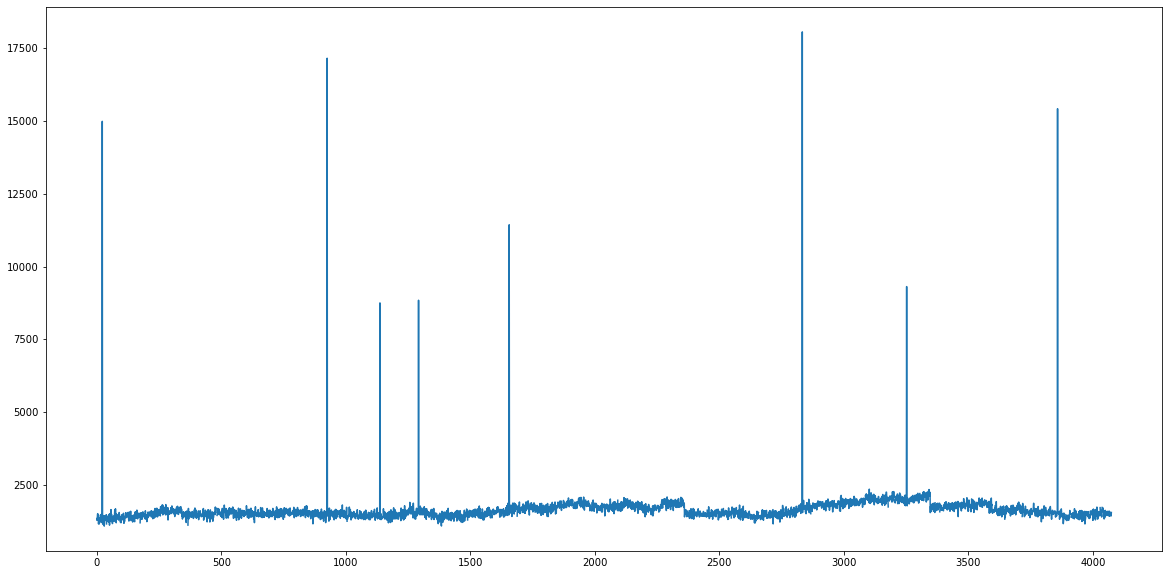

In [212]:
stock_id = 12

print(stocks_df[stock_id].head())

print(f'{stocks[stock_id]} stock prices between {stocks_df[stock_id].Date.min()} and {stocks_df[stock_id].Date.max()}')
print(f'Total trading Days = {(stocks_df[stock_id].Date.max() - stocks_df[stock_id].Date.min()).days}')
stocks_df[stock_id]['Close'].plot(figsize=(20,10))


Observed that there are outliers in **Utopian Financial Services** stock & needs to filter the data


1087.27 || 1386.664 || 18059.59200592522 || 2445.137296050268


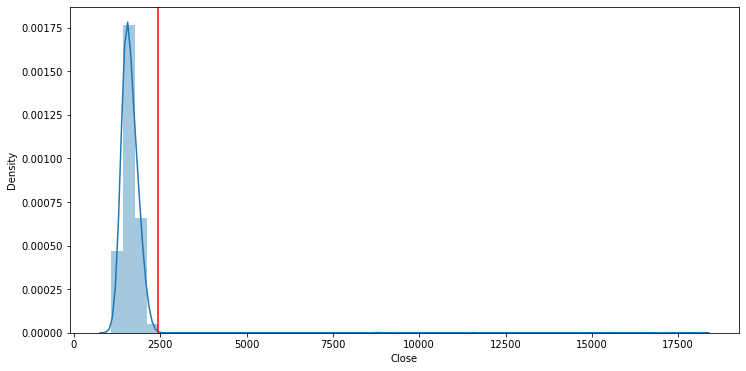

In [215]:

print(stocks_df[stock_id]['Close'].min(), '||', stocks_df[stock_id]['Close'].quantile(0.1), '||', 
stocks_df[stock_id]['Close'].max(), '||', stocks_df[stock_id]['Close'].quantile(0.998))

plt.figure(figsize=(12,6))
sns.distplot(stocks_df[stock_id]['Close']) # bins=50, kde=True, height=5, aspect=1.5)
plt.axvline(stocks_df[stock_id]['Close'].quantile(0.998), color='red')

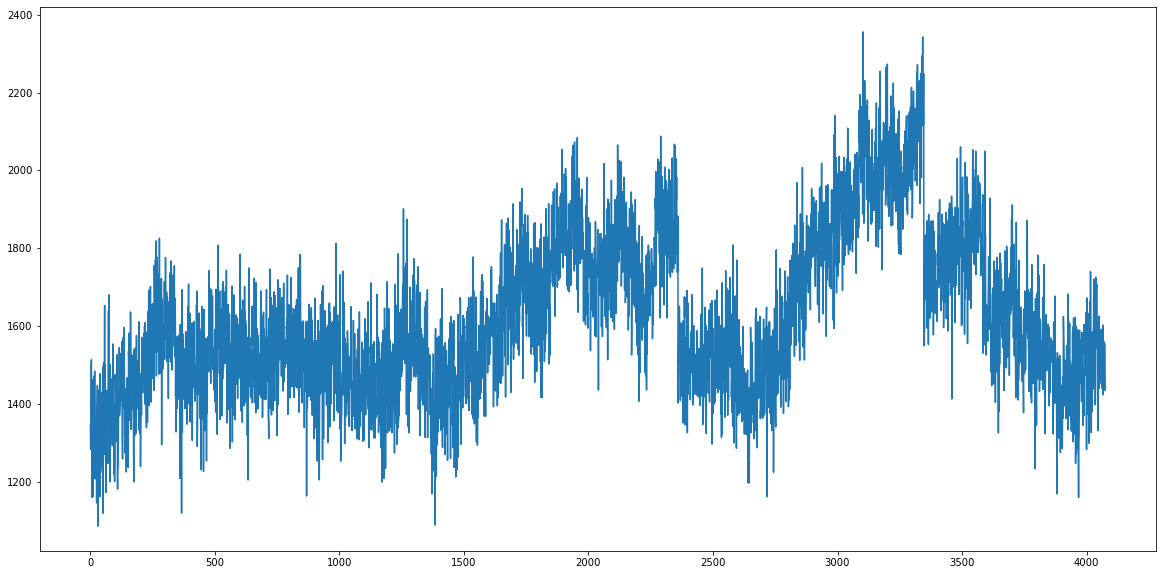

In [216]:

# removing the outliers
val = stocks_df[stock_id]['Close'].quantile(0.998)
stocks_df[stock_id] = stocks_df[stock_id][stocks_df[stock_id]['Close'] <= val]
stocks_df[stock_id]['Close'].plot(figsize=(20,10))
plt.show()

In [217]:

df = stocks_df[stock_id].reset_index()['Close']
print(df.head())
df.isnull().sum()

0    1346.45
1    1284.22
2    1341.98
3    1500.73
4    1513.98
Name: Close, dtype: float64


0


- There is no Null Data

Now preprocess the data & split the data into train & test


In [218]:

# preprocess the data 
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(np.array(df).reshape(-1,1))
scaled_data

# train test split
training_size = int(len(scaled_data)*0.8)
test_size = len(df)-training_size
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

print(f"Training_size : {training_size}, Test_size : {test_size} ")
print(train_data.shape, test_data.shape)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = data_reshaping(X_train)
X_test = data_reshaping(X_test)

# Generate LSTM Model
model = lstm_model(X_train)
model.summary()


Training_size : 3188, Test_size : 798 
(3188, 1) (798, 1)
(3127, 60) (3127,)
(737, 60) (737,)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_37 (LSTM)              (None, 60, 128)           131584    
                                                                 
 lstm_38 (LSTM)              (None, 128)               131584    
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                         

In [219]:
history = model_run(model, X_train, y_train, X_test, y_test, stocks, stock_id, 100, 64)

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.0924
Epoch 1: val_loss improved from inf to 0.03342, saving model to Utopian Financial Services_model.h5
49/49 [==============================] - 65s 1s/step - loss: 0.0924 - val_loss: 0.0334
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.0326
Epoch 2: val_loss improved from 0.03342 to 0.03219, saving model to Utopian Financial Services_model.h5
49/49 [==============================] - 58s 1s/step - loss: 0.0326 - val_loss: 0.0322
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.0326
Epoch 3: val_loss did not improve from 0.03219
49/49 [==============================] - 60s 1s/step - loss: 0.0326 - val_loss: 0.0378
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.0326
Epoch 4: val_loss did not improve from 0.03219
49/49 [==============================] - 60s 1s/step - loss: 0.0326 - val_loss: 0.0353
Epoch 5/100
49/49 [==============================]

In [220]:
f'{stocks[stock_id]}_model.h5'

'Utopian Financial Services_model.h5'

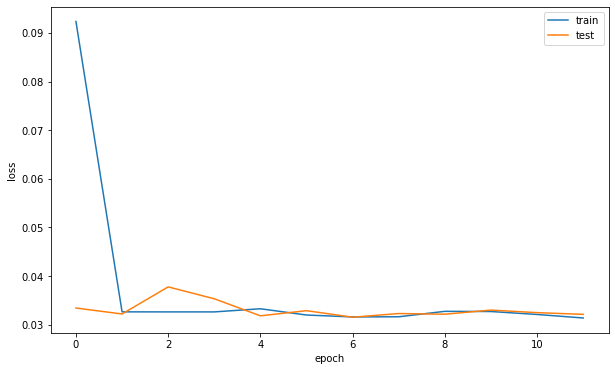

24/24 [==============================] - 3s 143ms/step
107.96486724834166 112.6042772520992


In [221]:
plt.figure(figsize=(10,6))
plot_losses(history)

saved_model = load_model(f'{stocks[stock_id]}_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=saved_model.predict(X_train)
test_predict=saved_model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)**0.5
test_rmse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_predict)**0.5

print(train_rmse, test_rmse)

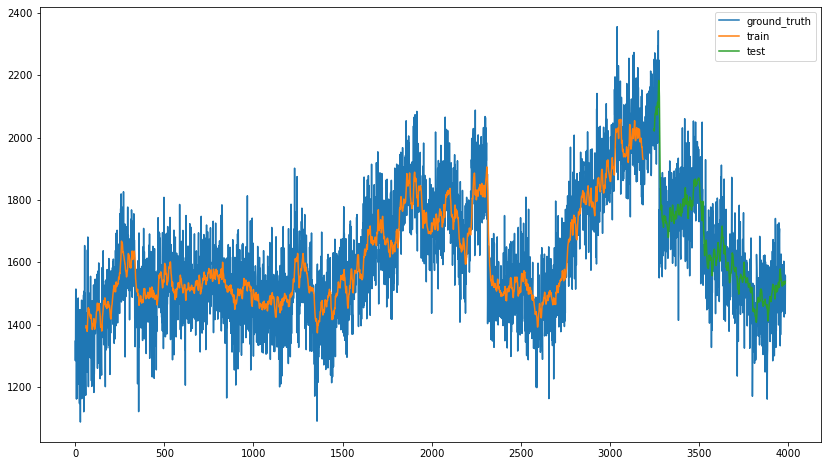

In [222]:
data_full = np.array(df).reshape(-1,1)
predicted_plots(train_predict, test_predict, data_full, 60)

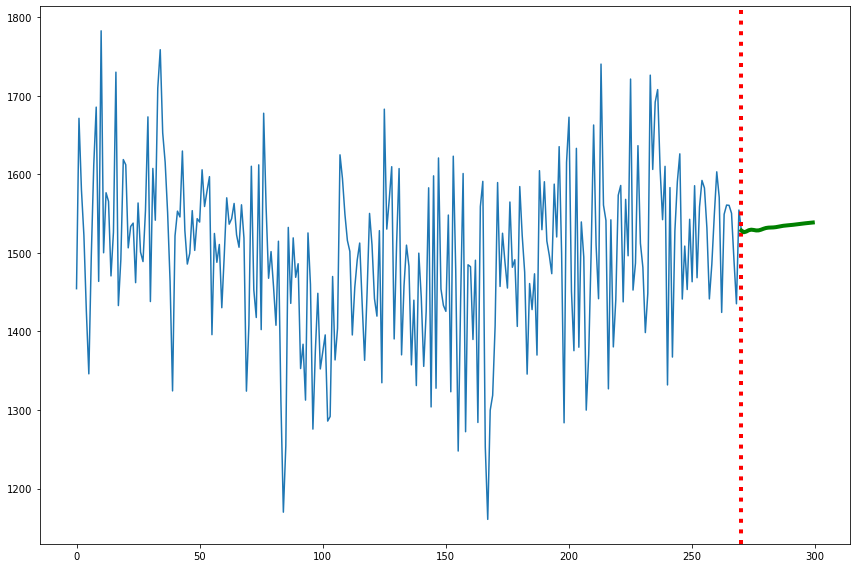

In [223]:
op = get_30_days_predictions(60, scaled_data, saved_model, 30)
plot_30_days_predict(np.array(df), op, scaler, 300)

Furthur Steps to improve model performance:

1. Hyperparameter tuning (Learning rate, w/wo dropout, no.of layers, neuron count, optimizers)
2. Using `keras.layers.TimeDistirbuted()` layer 
    - To predict the next 30 days
       - Current Approach - Used the trained model to predict the next day/value, then add that value to the inputs and use the model again to predict the following value (Refer `get_30_days_predictions` function in *utils.py*)
       - Proposed Approach (Sequence to Sequence) - Train the LSTM/RNN model to predict all next 30 values at once. For that we may directly add `keras.layers.Dense(30`) or we can use `keras.layers.TimeDistirbuted(Dense(30))`. `TimeDistributed` layer: It wraps any layer and applies it at every time step of its input sequence and I am hoping that proposed approach with (TimeDistributed) can improve the model performance